<div class="alert alert-info"><h1>
<font color=red>Real-Time Location System Case Study</font>
</h1>
</h2>

**Kevin Okiah, Shravan Kuchkula**


**06/17/2018**



## Abstract

In this Case Study, we explore prediction of location via Indoor Positioning System. The case study highlights and addresses the use of real-time location system (RTLS) technology and Wi-Fi in prediction of the location of a hand-held device within a building at the university of Mannheim. 

This Case Study is from Chapter 1 of **Data Science in R,  A Case Studies approach to Computational Reasoning and Problem solving**, book written by Deborah Nolan and Duncan Temple Lang. Location prediction is achieved by application of the k-nearest neighbors (kNN) clustering algorithm to a location data set. Weighted and unweighted kNN are both applied to the data, evaluated and compared against simple average predictions to determine the best prediction method.

## Introduction

With the growth of wireless networking, there has been a surge in interest from both commercial and research sectors of statistical methods to reliably track people and things inside stores, hospitals, warehouses, factories etc. [1]. 
While GPS is the pervasive solution for outdoor real-time locating, Real-time location systems (RTLS) comprising of tags, readers, and location sensing systems that accurately determine locations of people or objects in real-time has evolved and become much more prevalent for indoor tracking. This substantial stride in RTLS systems is attributed to the proliferation of wireless local area networks (LANs). 

Real Time Location System (RTLS) unit is a case study using the data that is available for the Nolan and Lang textbook website: http://rdatasciencecases.org/Data/offline.final.trace.txt

The offline data contains signal strengths measured using a hand-held device on a grid of 166 points spaced 1 meter apart in the hallways of one floor of a building at the University of Mannheim. The floor plan, which measures about 15 meters by 36 meters, is displayed in Figure 1.1. The grey circles on the plan mark the locations where the offline measurements were taken and the black squares mark 6 access points. These reference locations give us a calibration set of signal strengths for the building, and we use them to build our model to predict the locations of the hand-held device when its position is unknown.

![Floor Plan of the Test Environment](rtls_floor_plan.png)

In [1]:
options(digits = 2)
txt = readLines("offline.final.trace.txt")

## Methods 

This Methods section is broken down into the following sub-sections. 
* Data Preparation, cleaning and EDA;
* Signal strength analysis; 
* Implementation of kNN average weighting approach; 
* Implementation of kNN distance weighting approach;
* Comparison of kNN approaches 

In our analysis, We leverage the R code from `Deborah` and `Duncan` book Data Science in R: A Case Studies Approach to Computational Reasoning and Problem Solving, Chapter 1

<div class="alert alert-info"><h2>
<font color=blue>Data Preparation, cleaning and EDA</font>
</h2>


### Data Cleaning
Each line in the offline file has been read into R as a string in the character vector txt. We have a row in our data frame for each signal received. That is, each line in the input file turns into multiple rows in the data frame, corresponding to the number of ‘;’-separated MAC addresses in that line. For example, the first record in the input file becomes 11 rows and the 2000th observation becomes 8 rows in the data frame.

The documentation for the data describes the format of the data file. The avialable documentation indicates that the format of the data is:

```
t="Timestamp";
id="MACofScanDevice";
pos="RealPosition";
degree="orientation";
MACofResponse1="SignalStrengthValue,Frequency,Mode"; ...
MACofResponseN="SignalStrengthValue,Frequency,Mode"
```

In [2]:
head(txt)

[1] "# timestamp=2006-02-11 08:31:58"                                                                                                                                                                                                                                                                                                                                                                                                                                 
[2] "# usec=250"                                                                                                                                                                                                                                                                                                                                                                                                                                                      
[3] "# minReadings=110"                                                                                                                                                                                                                                                                                                                                                                                                                                               
[4] "t=1139643118358;id=00:02:2D:21:0F:33;pos=0.0,0.0,0.0;degree=0.0;00:14:bf:b1:97:8a=-38,2437000000,3;00:14:bf:b1:97:90=-56,2427000000,3;00:0f:a3:39:e1:c0=-53,2462000000,3;00:14:bf:b1:97:8d=-65,2442000000,3;00:14:bf:b1:97:81=-65,2422000000,3;00:14:bf:3b:c7:c6=-66,2432000000,3;00:0f:a3:39:dd:cd=-75,2412000000,3;00:0f:a3:39:e0:4b=-78,2462000000,3;00:0f:a3:39:e2:10=-87,2437000000,3;02:64:fb:68:52:e6=-88,2447000000,1;02:00:42:55:31:00=-84,2457000000,1"
[5] "t=1139643118744;id=00:02:2D:21:0F:33;pos=0.0,0.0,0.0;degree=0.0;00:14:bf:b1:97:8a=-38,2437000000,3;00:0f:a3:39:e1:c0=-54,2462000000,3;00:14:bf:b1:97:90=-56,2427000000,3;00:14:bf:3b:c7:c6=-67,2432000000,3;00:14:bf:b1:97:81=-66,2422000000,3;00:14:bf:b1:97:8d=-70,2442000000,3;00:0f:a3:39:e0:4b=-79,2462000000,3;00:0f:a3:39:dd:cd=-73,2412000000,3;00:0f:a3:39:e2:10=-83,2437000000,3;02:00:42:55:31:00=-85,2457000000,1"                                   
[6] "t=1139643119002;id=00:02:2D:21:0F:33;pos=0.0,0.0,0.0;degree=0.0;00:14:bf:b1:97:8a=-38,2437000000,3;00:0f:a3:39:e1:c0=-54,2462000000,3;00:14:bf:b1:97:90=-57,2427000000,3;00:14:bf:b1:97:81=-66,2422000000,3;00:14:bf:3b:c7:c6=-69,2432000000,3;00:14:bf:b1:97:8d=-70,2442000000,3;00:0f:a3:39:e0:4b=-78,2462000000,3;00:0f:a3:39:e2:10=-83,2437000000,3;00:0f:a3:39:dd:cd=-65,2412000000,3;02:64:fb:68:52:e6=-90,2447000000,1"

In [3]:
print(paste("# of comments lines = ",sum(substr(txt, 1, 1) == "#")))
print(paste("Total number of lines in the txt file = ", length(txt)))
print(paste("Actual location Data = ", length(txt)-sum(substr(txt, 1, 1) == "#")))

[1] "# of comments lines =  5312"
[1] "Total number of lines in the txt file =  151392"
[1] "Actual location Data =  146080"


From the 151392 lines in the offline txt file, we remain with 146,080 actual location data points when we eliminate the  5312 comments lines which begin with by '#'.

Each t row in converted into a matrix of 11x10 as shown above.

In [4]:
strsplit(txt[4], ";")[[1]]
tokens = strsplit(txt[4], "[;=,]")[[1]]
tokens[1:10]
tokens[c(2, 4, 6:8, 10)]
tokens[ - ( 1:10 ) ]

tmp = matrix(tokens[ - (1:10) ], ncol = 4, byrow = TRUE)
mat = cbind(matrix(tokens[c(2, 4, 6:8, 10)], 
                   nrow = nrow(tmp),
                   ncol = 6, 
                   byrow = TRUE), 
            tmp)

dim(mat)

processLine = function(x)
{
  tokens = strsplit(x, "[;=,]")[[1]]
  tmp = matrix(tokens[ - (1:10) ], ncol = 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp),
               ncol = 6, byrow = TRUE), tmp)
}

[1] "t=1139643118358"                    "id=00:02:2D:21:0F:33"              
 [3] "pos=0.0,0.0,0.0"                    "degree=0.0"                        
 [5] "00:14:bf:b1:97:8a=-38,2437000000,3" "00:14:bf:b1:97:90=-56,2427000000,3"
 [7] "00:0f:a3:39:e1:c0=-53,2462000000,3" "00:14:bf:b1:97:8d=-65,2442000000,3"
 [9] "00:14:bf:b1:97:81=-65,2422000000,3" "00:14:bf:3b:c7:c6=-66,2432000000,3"
[11] "00:0f:a3:39:dd:cd=-75,2412000000,3" "00:0f:a3:39:e0:4b=-78,2462000000,3"
[13] "00:0f:a3:39:e2:10=-87,2437000000,3" "02:64:fb:68:52:e6=-88,2447000000,1"
[15] "02:00:42:55:31:00=-84,2457000000,1"

[1] "t"                 "1139643118358"     "id"               
 [4] "00:02:2D:21:0F:33" "pos"               "0.0"              
 [7] "0.0"               "0.0"               "degree"           
[10] "0.0"

[1] "1139643118358"     "00:02:2D:21:0F:33" "0.0"              
[4] "0.0"               "0.0"               "0.0"

[1] "00:14:bf:b1:97:8a" "-38"               "2437000000"       
 [4] "3"                 "00:14:bf:b1:97:90" "-56"              
 [7] "2427000000"        "3"                 "00:0f:a3:39:e1:c0"
[10] "-53"               "2462000000"        "3"                
[13] "00:14:bf:b1:97:8d" "-65"               "2442000000"       
[16] "3"                 "00:14:bf:b1:97:81" "-65"              
[19] "2422000000"        "3"                 "00:14:bf:3b:c7:c6"
[22] "-66"               "2432000000"        "3"                
[25] "00:0f:a3:39:dd:cd" "-75"               "2412000000"       
[28] "3"                 "00:0f:a3:39:e0:4b" "-78"              
[31] "2462000000"        "3"                 "00:0f:a3:39:e2:10"
[34] "-87"               "2437000000"        "3"                
[37] "02:64:fb:68:52:e6" "-88"               "2447000000"       
[40] "1"                 "02:00:42:55:31:00" "-84"              
[43] "2457000000"        "1"

[1] 11 10

### Data cleaning: process each line

In [5]:
tmp = lapply(txt[4:20], processLine)

sapply(tmp, nrow)

offline = as.data.frame(do.call("rbind", tmp))
dim(offline)

lines = txt[ substr(txt, 1, 1) != "#" ]
tmp = lapply(lines, processLine)

processLine = function(x)
{
  tokens = strsplit(x, "[;=,]")[[1]]
  
  if (length(tokens) == 10) 
    return(NULL)
 
  tmp = matrix(tokens[ - (1:10) ], , 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow(tmp), 6, 
               byrow = TRUE), tmp)
}

options(error = recover, warn = 1)
tmp = lapply(lines, processLine)
offline = as.data.frame(do.call("rbind", tmp), 
                        stringsAsFactors = FALSE)

[1] 11 10 10 11  9 10  9  9 10 11 11  9  9  9  8 10 14

[1] 170  10

Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”

In [6]:
dim(offline)

[1] 1181628      10

In [7]:
head(offline)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8a,-38,2437000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:90,-56,2427000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:e1:c0,-53,2462000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8d,-65,2442000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:81,-65,2422000000,3
1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:3b:c7:c6,-66,2432000000,3


### Data cleaning: Add Column names, convert types

In [8]:
dim(offline)

names(offline) = c("time", "scanMac", "posX", "posY", "posZ", 
                   "orientation", "mac", "signal", 
                   "channel", "type")

numVars = c("time", "posX", "posY", "posZ", 
            "orientation", "signal")

# convert numeric columns to numeric.
offline[ numVars ] =  lapply(offline[ numVars ], as.numeric)

# filter type = 3 rows
offline = offline[ offline$type == "3", ]

# remove type column
offline = offline[ , "type" != names(offline) ]
dim(offline)

offline$rawTime = offline$time
offline$time = offline$time/1000
class(offline$time) = c("POSIXt", "POSIXct")

unlist(lapply(offline, class))

[1] 1181628      10

[1] 978443      9

time1       time2     scanMac        posX        posY        posZ 
   "POSIXt"   "POSIXct" "character"   "numeric"   "numeric"   "numeric" 
orientation         mac      signal     channel     rawTime 
  "numeric" "character"   "numeric" "character"   "numeric"

      time                          posX         posY           posZ  
 Min.   :2006-02-11 02:31:58   Min.   : 0   Min.   : 0.0   Min.   :0  
 1st Qu.:2006-02-11 08:21:27   1st Qu.: 2   1st Qu.: 3.0   1st Qu.:0  
 Median :2006-02-11 14:57:58   Median :12   Median : 6.0   Median :0  
 Mean   :2006-02-16 09:57:37   Mean   :14   Mean   : 5.9   Mean   :0  
 3rd Qu.:2006-02-19 09:52:40   3rd Qu.:23   3rd Qu.: 8.0   3rd Qu.:0  
 Max.   :2006-03-09 15:41:10   Max.   :33   Max.   :13.0   Max.   :0  
  orientation      signal   
 Min.   :  0   Min.   :-99  
 1st Qu.: 90   1st Qu.:-69  
 Median :180   Median :-60  
 Mean   :167   Mean   :-62  
 3rd Qu.:270   3rd Qu.:-53  
 Max.   :360   Max.   :-25  

                mac               channel                    scanMac      
 00:0f:a3:39:e1:c0:145862   2462000000:189774   00:02:2D:21:0F:33:978443  
 00:0f:a3:39:dd:cd:145619   2437000000:152124                             
 00:14:bf:b1:97:8a:132962   2412000000:145619                             
 00:14:bf:3b:c7:c6:126529   2432000000:126529                             
 00:14:bf:b1:97:90:122315   2427000000:122315                             
 00:14:bf:b1:97:8d:121325   2442000000:121325                             
 (Other)          :183831   (Other)   :120757                             

[1] 203

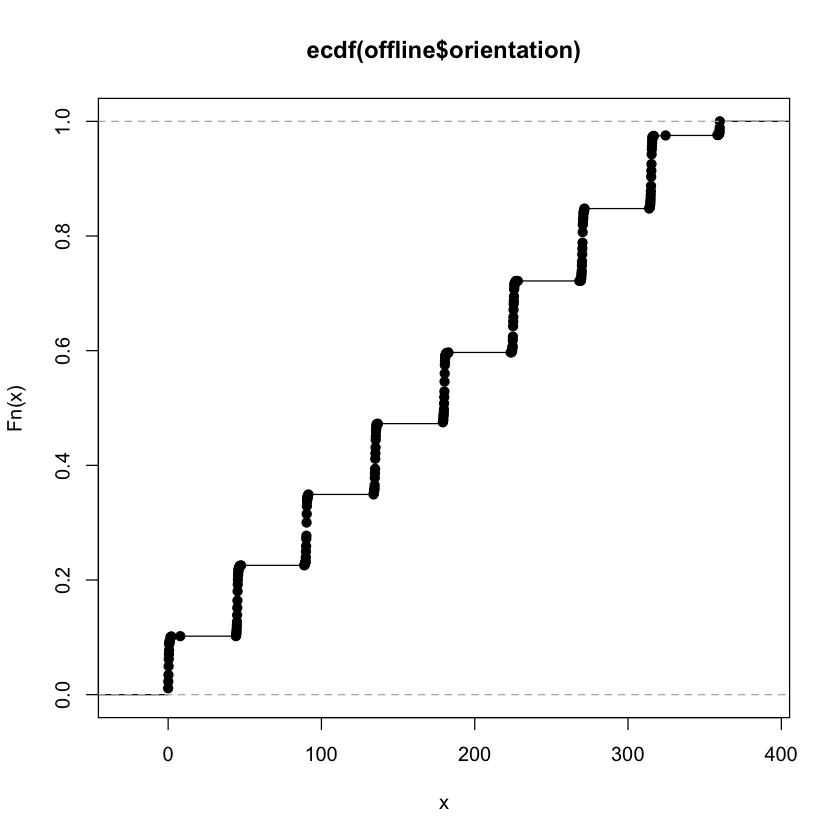

null device 
          1

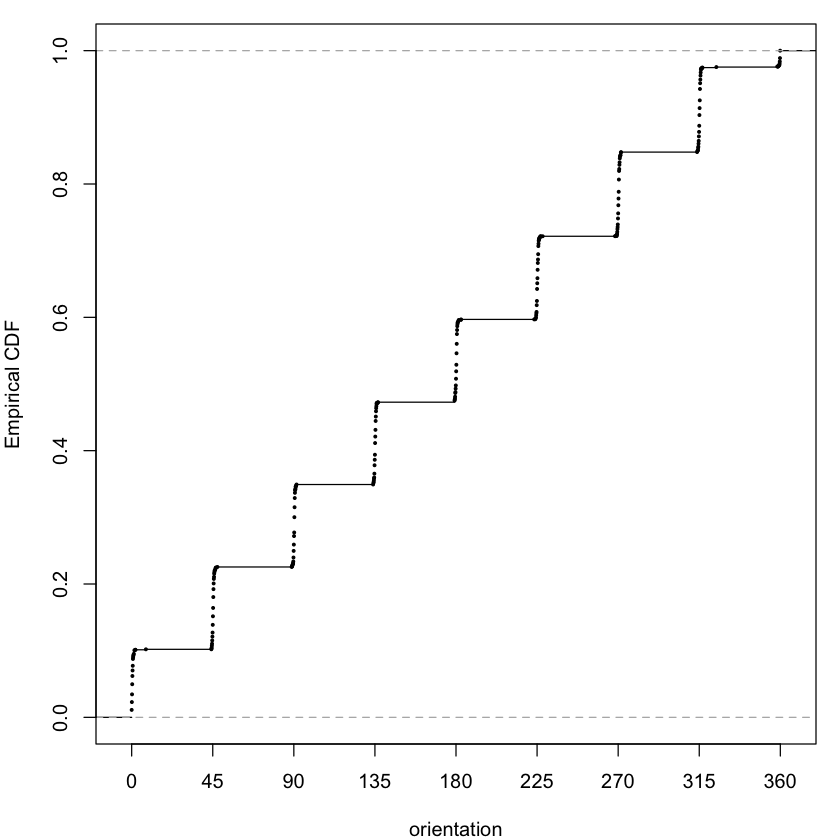

In [9]:
summary(offline[, numVars])

 summary(sapply(offline[ , c("mac", "channel", "scanMac")],
                as.factor))

offline = offline[ , !(names(offline) %in% c("scanMac", "posZ"))]

length(unique(offline$orientation))

plot(ecdf(offline$orientation))

#pdf(file = "Geo_ECDFOrientation.pdf", width = 10, height = 7)
oldPar = par(mar = c(4, 4, 1, 1))
plot(ecdf(offline$orientation), pch = 19, cex = 0.3,
     xlim = c(-5, 365), axes = FALSE,
     xlab = "orientation", ylab = "Empirical CDF", main = "")
box()
axis(2)
axis(side = 1, at = seq(0, 360, by = 45))
par(oldPar)
dev.off()

### Data cleaning: Create Angle by summarizing orientation

Warning message:
“In density.default(offline$orientation, bw = 2, sub = "Caption for the figure") :
 extra argument ‘sub’ will be disregarded”

null device 
          1

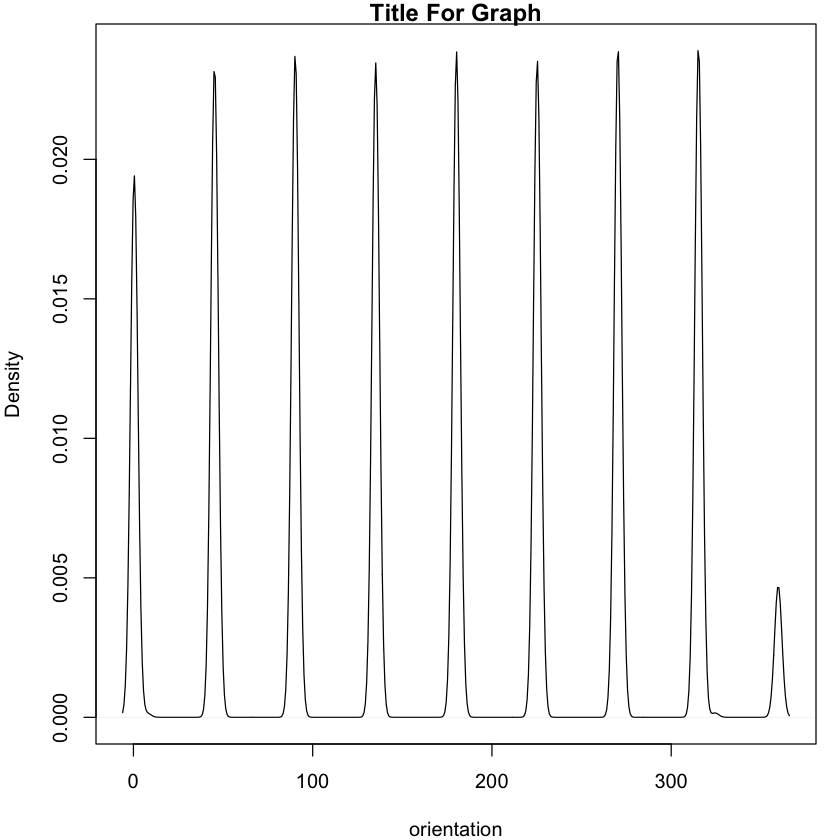

In [10]:
#pdf(file = "Geo_DensityOrientation.pdf", width = 10, height = 5)
oldPar = par(mar = c(4, 4, 1, 1))
plot(density(offline$orientation, bw = 2,sub="Caption for the figure"), 
 xlab = "orientation", main = "")
title("Title For Graph")

par(oldPar)
dev.off()

roundOrientation = function(angles) {
  refs = seq(0, by = 45, length  = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
}



The Empirical CDF figure above shows that while the values are not strictly in 45 degree increments, they are close to one of the expected values as shown in the box plot figure below. This means that while they are not exact, they are close to a target orientation value. The code below takes the orientation value from each row and assigns it to the closest expected orientation value. The outlier on the top left corner of the box plot below are values close to 360  that have been mapped as zero.

null device 
          1

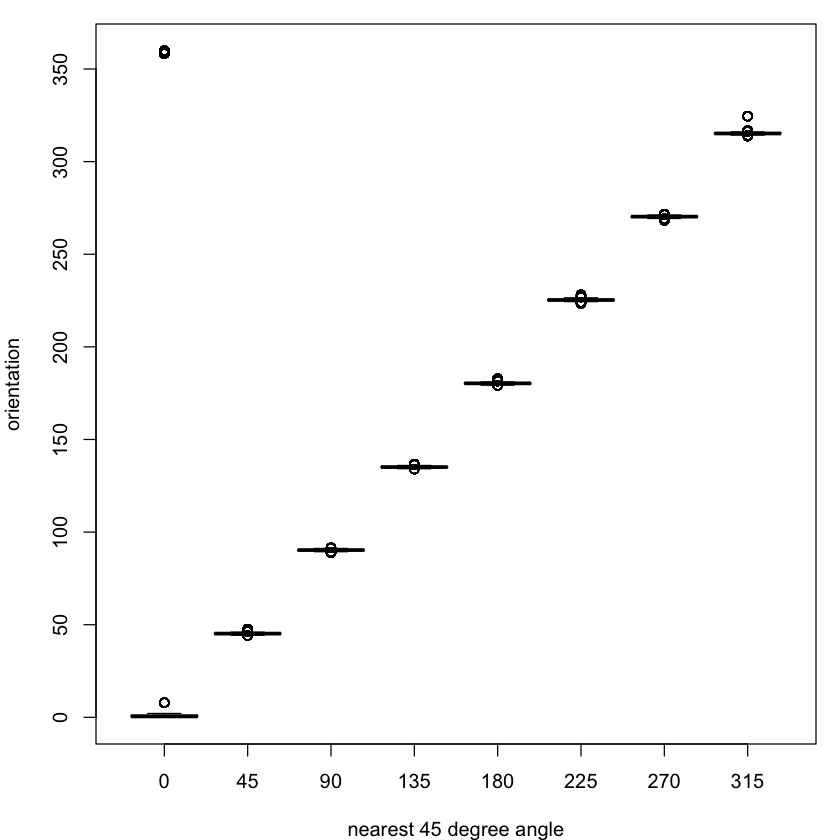

In [11]:
offline$angle = roundOrientation(offline$orientation)

#pdf(file = "Geo_BoxplotAngle.pdf", width = 10)
oldPar = par(mar = c(4, 4, 1, 1))
 with(offline, boxplot(orientation ~ angle,
    xlab = "nearest 45 degree angle",
    ylab="orientation"))            
             

dev.off()

### Exploring the relationship between MAC address and channel

In [12]:
c(length(unique(offline$mac)), length(unique(offline$channel)))

[1] 12  8

There are 12 MAC addresses and 8 channels. We were given the impression from the building plan (see Figure 1.1) that there are only 6 access points. Why are there 8 channels and 12 MAC addresses? Rereading the documentation we find that there are additional access points that are not part of the testing area and so not seen on the floor plan.

Let’s check the counts of observations for the various MAC addresses with table()

In [13]:
table(offline$mac)


00:04:0e:5c:23:fc 00:0f:a3:39:dd:cd 00:0f:a3:39:e0:4b 00:0f:a3:39:e1:c0 
              418            145619             43508            145862 
00:0f:a3:39:e2:10 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
            19162            126529            120339            132962 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 00:30:bd:f8:7f:c5 00:e0:63:82:8b:a9 
           121325            122315               301               103 

Clearly the first and the last two MAC addresses are not near the testing area or were only working/active for a short time during the measurement process because their counts are very low. It’s probably also the case that the third and fifth addresses are not among the access points displayed on the map because they have much lower counts than the others and these are far lower than the possible 146,080 recordings (recall that there are potentially signals recorded at 166 grid points, 8 orientations, and 110 replications). 

According to the documentation, the access points consist of `5 Linksys/Cisco` and `one Lancom L-54g routers`. We look up these MAC addresses at the http://coffer.com/ mac_find/ site to find the vendor addresses that begin with **00:14:bf** belong to **Linksys devices**. Those beginning with *00:0f:a3 belong to Alpha Networks*, and **Lancom devices** start with **00:a0:57**.  

However, none of our MAC addresses begin with 00:a0:57 so there is a discrepancy with the documentation. Nonetheless, we have discovered valuable information for piecing together a better understanding of the data. For now, let’s keep the records from the top **7 devices.**

In [14]:
subMacs = names(sort(table(offline$mac), decreasing = TRUE))[1:7]
offline = offline[ offline$mac %in% subMacs, ]

In [16]:
dim(offline)

[1] 914951      9

Finally, we create a table of counts for the remaining MAC×channel combinations and confirm there is one non-zero entry in each row

In [18]:
macChannel = with(offline, table(mac, channel))
apply(macChannel, 1, function(x) sum(x > 0))

00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 
                1                 1                 1                 1 
00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
                1                 1                 1

Indeed we see that there is a one-to-one correspondence between MAC address and channel for these 7 devices. No statistical significance will be gained by keeping both and if anything this could lead to unwanted correlation between variables. This means we can eliminate channel from offline, i.e.,

In [19]:
offline = offline[ , "channel" != names(offline)]

### Exploring Hand-Held device Position

Lastly, we consider the position variables, posX and posY. For how many different locations do we have data? The by() function can tally up the numbers of rows in our data frame for each unique (x, y) combination. We begin by creating a list containing a data frame for each location as follows:

In [20]:
locDF = with(offline, 
             by(offline, list(posX, posY), function(x) x))
length(locDF)

[1] 476

Note that this list is longer than the number of combinations of actual (x,y) locations at which measurements were recorded. Many of these elements are empty:

In [21]:
sum(sapply(locDF, is.null))

[1] 310

The null values correspond to the combinations of the xs and ys that were not observed. We drop these unneeded elements as follows:

In [22]:
locDF = locDF[ !sapply(locDF, is.null) ]

length(locDF)

[1] 166

This confirms that we now have only 166 locations. We can operate on each of these data frames to, e.g., determine the number of observations recorded at each location with:

In [23]:
locCounts = sapply(locDF, nrow)
locCounts

[1] 5505 5505 5506 5524 5543 5558 5503 5564 5513 5529 5526 5549 5526 5469 5464
 [16] 5525 5429 5499 5532 5482 5396 5443 5358 5468 5447 5486 5483 5468 5444 5448
 [31] 5503 5496 5472 5533 5459 5493 5543 5481 5539 5527 5490 5522 5433 5554 5463
 [46] 5480 5409 5424 5526 5538 5442 5585 5556 5542 5526 5486 5560 5519 5507 5474
 [61] 5447 5552 5500 5538 5365 5507 5409 5520 5551 5531 5615 5530 5517 5535 5474
 [76] 5483 5541 5447 5506 5513 5519 5499 5576 5492 5473 5426 5529 5567 5528 5553
 [91] 5595 5581 5519 5506 5437 5534 5536 5349 5331 5440 5448 5411 5470 5472 5671
[106] 5541 5514 5543 5452 5527 5543 5593 5540 5531 5539 5621 5624 5495 5450 5500
[121] 5638 5586 5592 5619 5603 5626 5477 5585 5588 5475 5559 5367 5461 5309 5330
[136] 5535 5395 5361 5494 5475 5493 5481 5573 5527 5556 5504 5545 5553 5579 5692
[151] 5540 5492 5487 5589 5463 5596 5557 5488 5523 5656 5524 5544 5734 5523 5553
[166] 5774

The matrix above gives the exact counts for each position. The number of data points per position are not equal but they are relatively close (~5,500) meaning our data should not be biased by the position variable.

And, if we want to keep the position information with the location, we do this with the code below

In [24]:
locCounts = sapply(locDF, 
                   function(df) 
                     c(df[1, c("posX", "posY")], count = nrow(df)))
class(locCounts)

dim(locCounts)

locCounts[ , 1:8]

[1] "matrix"

[1]   3 166

posX,0,1,2,0,1,2,0,1
posY,0,0,0,1,1,1,2,2
count,5505,5505,5506,5524,5543,5558,5503,5564


Above we confirm that locCounts is a matrix with 3 rows and we examine a few columns.

We see that there are roughly 5,500 recordings at each position. This is in accord with 8 orientations × 110 replications × 7 access points, which is 6,160 signal strength measurements.

We can visualize all 166 counts by adding the counts as text at their respective locations, changing the size and angle of the characters to avoid overlapping text. We first transpose the matrix so that the locations are columns of the matrix and then we make our plot with

null device 
          1

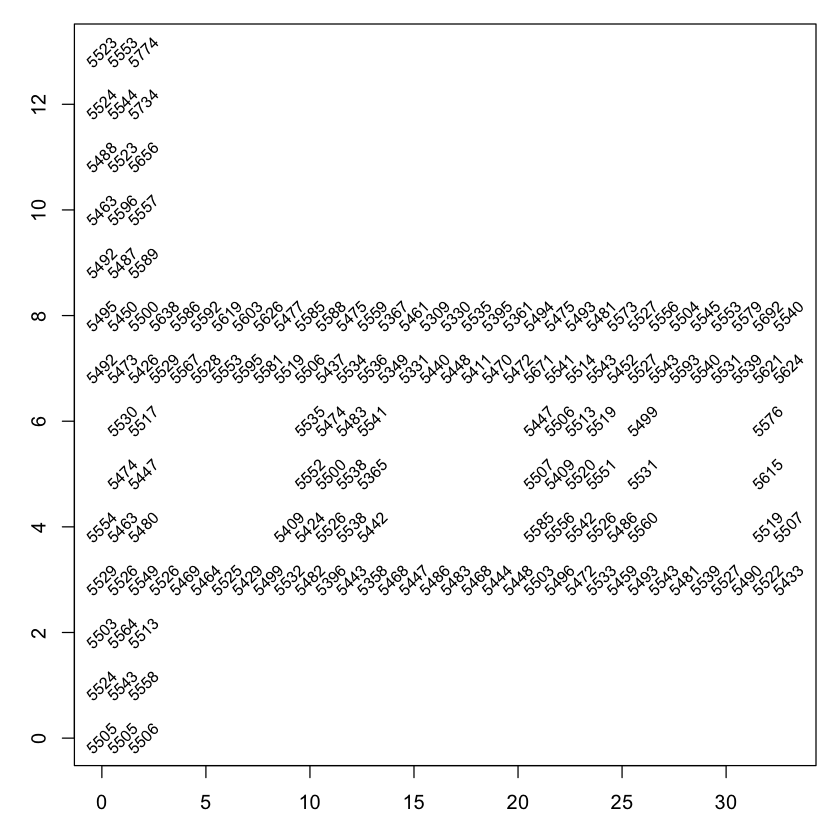

In [25]:
#pdf(file = "Geo_XYByCount.pdf", width = 10)
oldPar = par(mar = c(3.1, 3.1, 1, 1))

locCounts = t(locCounts)
plot(locCounts, type = "n", xlab = "", ylab = "")
text(locCounts, labels = locCounts[,3], cex = .8, srt = 45)

par(oldPar)
dev.off()

We see in Figure 1.5 that there are roughly the same number of signals detected at each location.

## Creating a function to prepare the data
We have examined all the variables except time and signal. This process has helped us clean our data and reduce it to those records that are relevant to our analysis. We leave the examination of the signals to the next section where we study its distributional properties.

Since we also want to read the online data in R, we turn all of these commands into a function called readData(). Additionally, if we later change our mind as to how we want to handle some of these special cases, e.g., to keep channel or posZ, then we can make a simple update to our function and rerun it. We might even add a parameter to the function definition to allow us to process the data in different ways.

In [26]:
# Function to prepare the data
readData = function(filename = 'offline.final.trace.txt', 
           subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81")){
    txt = readLines(filename)
    lines = txt[ substr(txt, 1, 1) != "#" ]
    tmp = lapply(lines, processLine)
    offline = as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    
    names(offline) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
     # keep only signals from access points
    offline = offline[ offline$type == "3", ]
    
    # drop scanMac, posZ, channel, and type - no info in them
    dropVars = c("scanMac", "posZ", "channel", "type")
    offline = offline[ , !( names(offline) %in% dropVars ) ]
    
    # drop more unwanted access points
    offline = offline[ offline$mac %in% subMacs, ]
    
    # convert numeric values
    numVars = c("time", "posX", "posY", "orientation", "signal")
    offline[ numVars ] = lapply(offline[ numVars ], as.numeric)

    # convert time to POSIX
    offline$rawTime = offline$time
    offline$time = offline$time/1000
    class(offline$time) = c("POSIXt", "POSIXct")
    
    # round orientations to nearest 45
    offline$angle = roundOrientation(offline$orientation)
      
    return(offline)
  }

offlineRedo = readData()

identical(offline, offlineRedo)

[1] TRUE

We call `readData()` to create the offline data frame and then we use the `identical()` function to check the version of the data frame against the one that we already created. It returns TRUE. This confirms that our function behaves as expected.

<div class="alert alert-info"><h2>
<font color=blue>Signal Strength Analysis</font>
</h2>


Having used visualization and statistical summaries to help clean and format the data, we now turn to investigating the properties of the response variable, `signal strength`.

We want to learn more about how the signals behave before designing a model for IPS. The following questions guide us in our investigations:

*We have measured the signal strength to an access point multiple times at each location and orientation. How do these signal strengths behave? That is, what is the distribution of the repeated measurements at each location and orientation? Does signal strength behave similarly at all locations? Or does, the location, orientation, and access point affect this distribution?*

In [230]:
# From each of the 166 locations, these many number of signals were recorded.
# In 8 orientations 110 signal measurements were taken to each of the 6 access points.
# orientations x measurements x accessPoints
8 * 110 * 6

[1] 5280

### Distribution of Signal Strength
We want to compare the distribution of signal strength at different orientations and for different access points, so we need to subdivide our data. We are interested in seeing if these distributions are normal or skewed. We also want to look at their variances.

#### Impact of orientation on signal strength by fixing a location
We consider the impact of orientation on signal strength by fixing a location on the map to see how the signal changes as the experimenter rotates through the 8 angles.

We also separately examine the MAC addresses because, for example, at an orientation of 90 degrees the experimenter may be facing toward one access point and away from another. To do this we make simple boxplots with the bwplot() function in the lattice package. 

Note here that we are removing MAC address `00:0f:a3:39:dd:cd` from our analysis.

null device 
          1

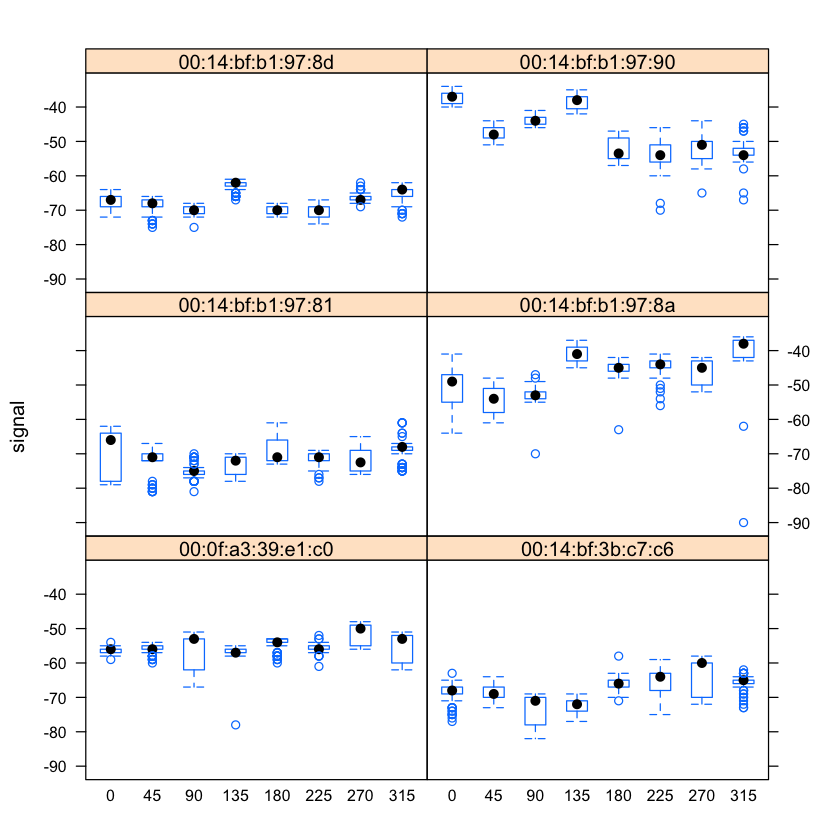

In [27]:
#pdf(file = "Geo_BoxplotSignalByMacAngle.pdf", width = 7)
oldPar = par(mar = c(3.1, 3, 1, 1))

library(lattice)
bwplot(signal ~ factor(angle) | mac, 
       data = offline, 
       subset = posX == 2 & posY == 12 & mac != "00:0f:a3:39:dd:cd", 
       layout = c(2,3))

par(oldPar)
dev.off()

We see in Figure 1.6 that the signal strength varies with the orientation for both close and distant access points.

**Note we have dropped the records for the MAC address of 00:0f:a3:39:dd:cd because it is identified as the extra address in the next section.** 

### Analyzing the signal distribution for 2 Mac addresses
In Figure 1.6, we see that we have decided to use only 6 MAC addresses by dropping `00:0f:a3:39:dd:cd`. It might be useful to check how the signal distribution varies for this mac address in particular to help us understand why we dropped this particular mac address.

null device 
          1

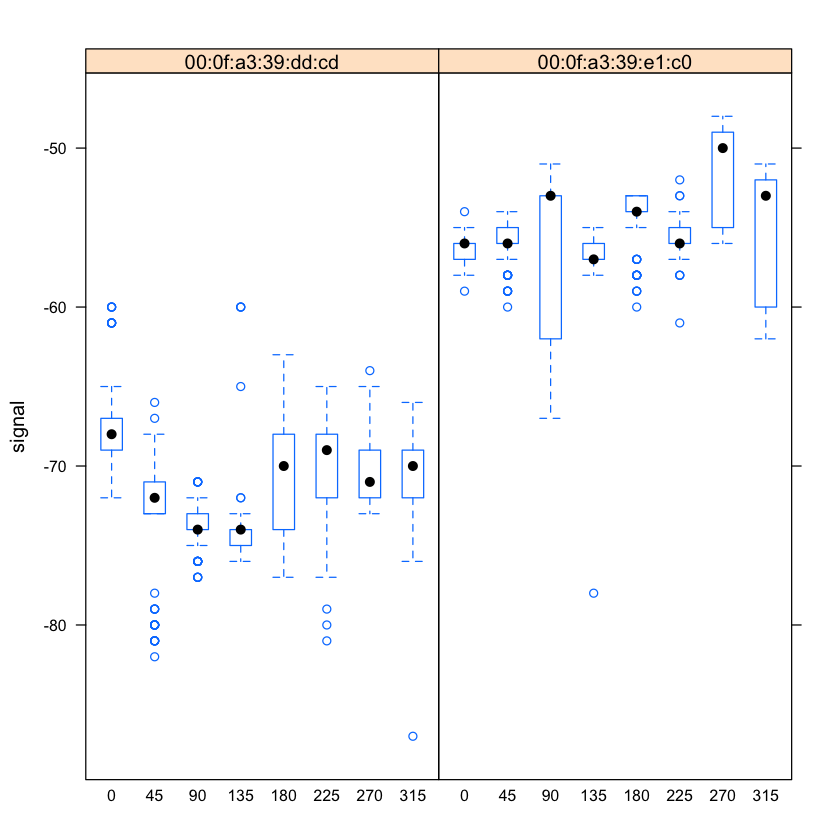

In [28]:
# Signal distribution for mac address 00:0f:a3:39:dd:cd
oldPar = par(mar = c(3.1, 3, 1, 1))

library(lattice)
bwplot(signal ~ factor(angle) | mac, 
       data = offline, 
       subset = posX == 2 & posY == 12 & mac %in% c("00:0f:a3:39:e1:c0","00:0f:a3:39:dd:cd"), 
       layout = c(2,1))

par(oldPar)
dev.off()

Looking at the boxplots, it appears that the signal strength value for the dropped mac address `00:0f:a3:39:dd:cd` at this particular location is weaker compared to the retained mac address `00:0f:a3:39:e1:c0`. 

Recall from the summary statistics that signal strengths are measured in negative values. That is:

In [29]:
summary(offline$signal)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    -98     -67     -59     -60     -53     -25 

The small values, such as -98, correspond to weak signals and the large values, such as -25, are the strong signals.

When we examine a few other locations, we find a similar dependence of signal strength on angle. For example, we compare the distributions of signal strength for different angles and MAC addresses at the central location of x = 23 and y = 4; we use the densityplot() function in the lattice package because it makes it easy to condition on these variables. We produce 48 density curves for this one location with

null device 
          1

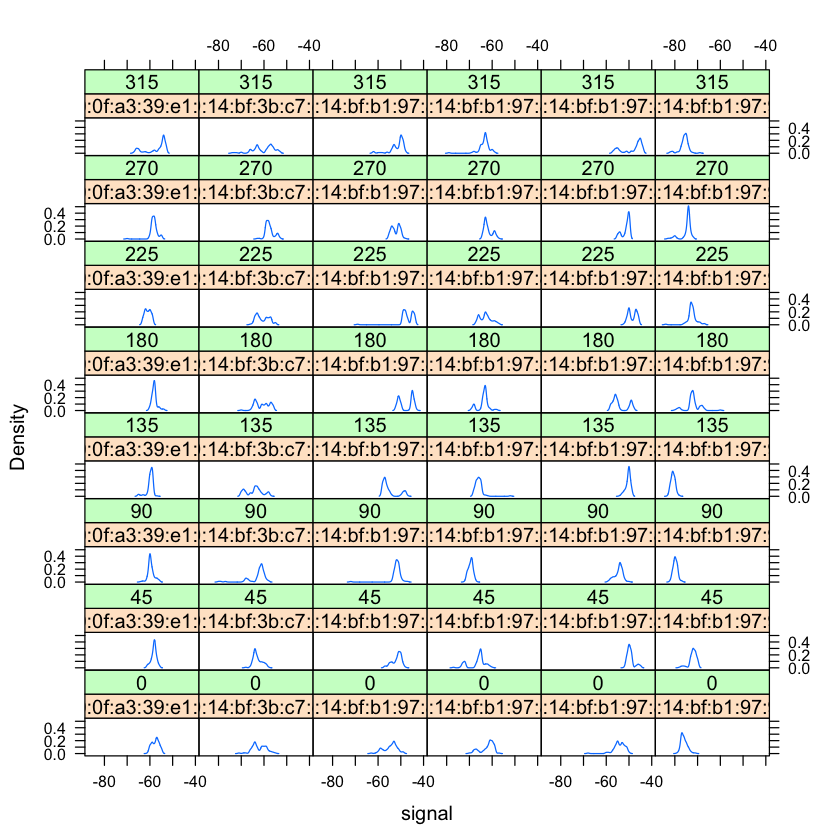

In [30]:
#pdf(file = "Geo_DensitySignalByMacAngle.pdf", width = 8, height = 12)
oldPar = par(mar = c(3.1, 3, 1, 1))

densityplot( ~ signal | mac + factor(angle), data = offline,
             subset = posX == 24 & posY == 4 & 
                         mac != "00:0f:a3:39:dd:cd",
             bw = 0.5, plot.points = FALSE)

par(oldPar)
dev.off()

Many of these distributions look approximately normal, but there are some serious departures with secondary modes and skewness (see Figure 1.7). Also, the center of the distribution varies with angle and MAC address, which indicates that conditioning on angle and MAC address is warranted. 

### Comparing the density plots for 2 mac address

null device 
          1

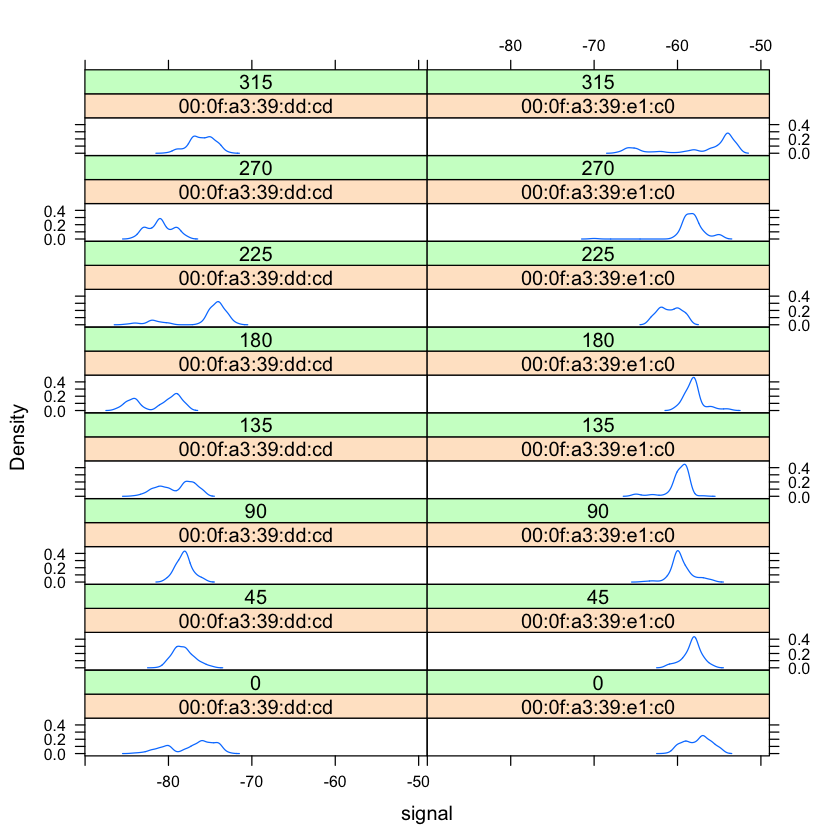

In [31]:
#pdf(file = "Geo_DensitySignalByMacAngle.pdf", width = 8, height = 12)
oldPar = par(mar = c(3.1, 3, 1, 1))

densityplot( ~ signal | mac + factor(angle), data = offline,
             subset = posX == 24 & posY == 4 & 
                         mac %in% c("00:0f:a3:39:dd:cd", "00:0f:a3:39:e1:c0"),
             bw = 0.5, plot.points = FALSE)

par(oldPar)
dev.off()

The density plots for these 2 mac addresses reveal the same insight that we derived from plotting the boxplots. That is, the mac address `00:0f:a3:39:dd:cd` has weaker signal values for all orientations at this particular location x = 24 and y = 4 (approximately center point on the floor). 

If we want to examine the distribution of signal strength for all 166 locations, 8 angles, and 6 access points, we need to create thousands of boxplots or density curves. We can, instead, examine summary statistics such as the mean and SD or the median and IQR of signal strength for all location–orientation–access point combinations.

For each combination, we have roughly 100 observations. To compute summary statistics for these various combinations, we first create a special factor that contains all of the unique combinations of the observed (x, y) pairs for the 166 locations. We can do this with

In [32]:
offline$posXY = paste(offline$posX, offline$posY, sep = "-")

In [33]:
# Remove this
length(unique(offline$mac))

[1] 7

**Note:** We still have 7 Mac Addresses at this point.

Next, we create a list of data frames for every combination of (x, y), angle, and access point as follows

In [34]:
byLocAngleAP = with(offline, 
                    by(offline, list(posXY, angle, mac), 
                       function(x) x))

Then we can calculate summary statistics on each of these data frames with

In [35]:
signalSummary = lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })
offlineSummary = do.call("rbind", signalSummary) 

### OfflineSummary
This dataframe contains summary data broken down by Location, Angle  and AccessPoint. It includes 7 mac addresses. 

In [36]:
head(offlineSummary)

,time,posX,posY,orientation,mac,signal,rawTime,angle,posXY,medSignal,avgSignal,num,sdSignal,iqrSignal
7,2006-02-11 02:31:58,0,0,0.0,00:0f:a3:39:dd:cd,-75,1.1e+12,0,0-0,-67,-68,111,3.2,4.5
24512,2006-02-11 03:03:44,0,1,0.7,00:0f:a3:39:dd:cd,-73,1.1e+12,0,0-1,-70,-70,110,2.4,3.0
221777,2006-02-11 06:46:02,0,10,0.9,00:0f:a3:39:dd:cd,-69,1.1e+12,0,0-10,-67,-69,111,4.4,6.5
229191,2006-02-11 06:54:05,0,11,0.4,00:0f:a3:39:dd:cd,-72,1.1e+12,0,0-11,-73,-74,111,5.4,7.0
236493,2006-02-11 07:02:32,0,12,0.2,00:0f:a3:39:dd:cd,-72,1.1e+12,0,0-12,-70,-70,114,2.4,3.0
243546,2006-02-11 07:14:12,0,13,0.1,00:0f:a3:39:dd:cd,-69,1.1e+12,0,0-13,-74,-74,109,3.5,4.0


Let’s examine the standard deviations and see if they vary with the average signal strength. We can make boxplots of sdSignal for subgroups of avgSignal by turning avgSignal into a categorical variable. Here, we first examine this by removing the access point with mac address `00:0f:a3:39:dd:cd`. As we are comparing the the mean signal strength with standard deviation of the signal, it matters little which mac address we choose to omit.

null device 
          1

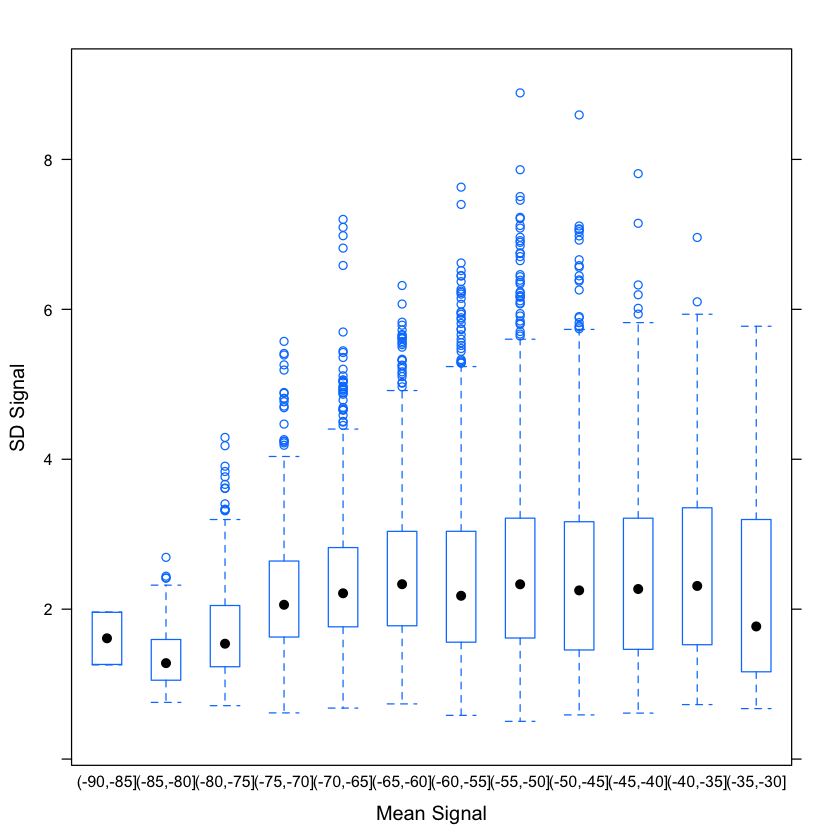

In [37]:
#pdf(file = "Geo_BoxplotSignalSDByAvg.pdf", width = 10)
oldPar = par(mar = c(3.1, 3, 1, 1))

breaks = seq(-90, -30, by = 5)
bwplot(sdSignal ~ cut(avgSignal, breaks = breaks),
       data = offlineSummary, 
       subset = mac != "00:0f:a3:39:dd:cd",
       xlab = "Mean Signal", ylab = "SD Signal")

par(oldPar)
dev.off()

We see in Figure 1.8 that the weakest signals have small standard deviations and that it appears that the SD increases with the average signal strength. If we plan to model the behavior of signal strength, then we want to take these features into consideration.

We examine the skewness of signal strength by plotting the difference, avgSignal - medSignal, against the number of observations. We do this with the smoothScatter() function so that we avoid problems with over plotting and we also add a local average of the difference between the mean and median to better help us assess its size. We use loess() to locally smooth the differences between the mean and median. Then we use the fitted model to predict the difference for each value of num and add these predictions to the scatter plot. 

null device 
          1

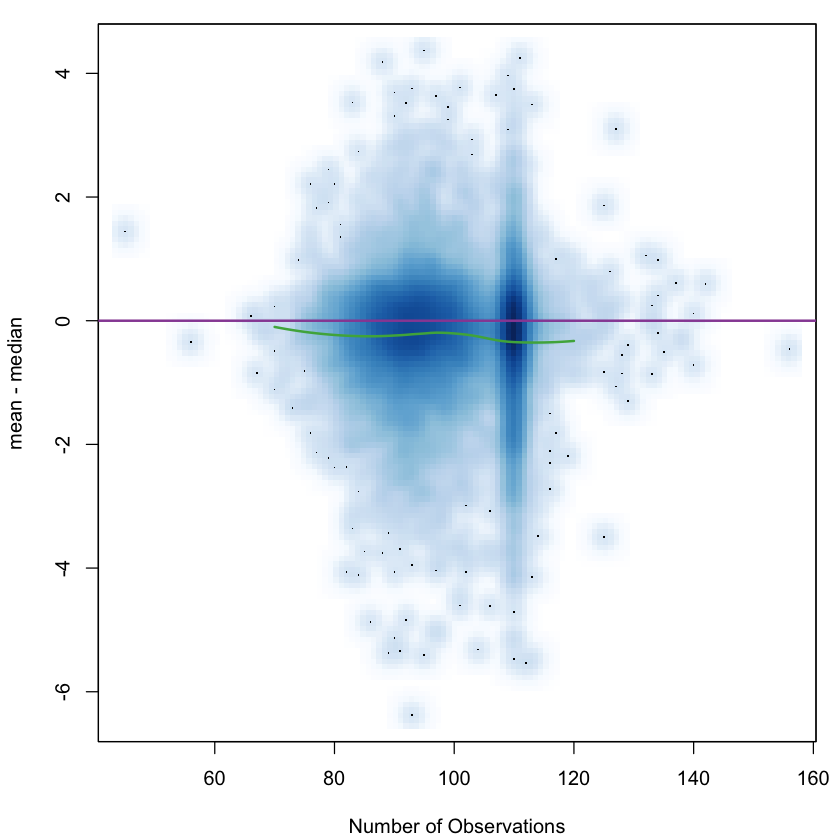

In [39]:
#pdf(file = "Geo_ScatterMean-Median.pdf", width = 10)
oldPar = par(mar = c(4.1, 4.1, 1, 1))

with(offlineSummary,
     smoothScatter((avgSignal - medSignal) ~ num,
                   xlab = "Number of Observations", 
                   ylab = "mean - median"))
abline(h = 0, col = "#984ea3", lwd = 2)

lo.obj = 
  with(offlineSummary,
       loess(diff ~ num, 
             data = data.frame(diff = (avgSignal - medSignal),
                               num = num)))

lo.obj.pr = predict(lo.obj, newdata = data.frame(num = (70:120)))
lines(x = 70:120, y = lo.obj.pr, col = "#4daf4a", lwd = 2)

par(oldPar)
dev.off()

# removed this
#oneAPAngle = subset(offlineSummary, mac == subMacs[5] & angle == 0)

From Figure 1.9 we see that these two measures of centrality are similar to each other; they typically differ by less than 1 to 2 dBm.

Until now we have seen how signal is distributed with respect to Angle. Now we get into checking the relationship between signal and distance.

## Relationship between signal and distance
One way to examine the relationship between distance and signal strength is to smooth the signal strength over the region where it is measured and create a contour plot, similar to a topographical map; that portion of the floor plan where there is strong signal corresponds to the mountainous regions in the contour map. As with our previous analysis of signal strength, we want to control for the access point and orientation. We select one mac address and one orientation to examine this relationship.

We can make a topographical map using color, i.e., a heat map. The fields package uses the method of thin plate splines to fit a surface to the signal strength values at the observed locations. This package also provides plotting routines for visualizing the surface with a heat map. The Tps() function in fields requires that we provide a unique “z” value for each (x, y) so we must summarize our signal strengths. Rather than use offline, which gives, in oneAPAngle, about 100 recordings of signal strength at each location, we subset offlineSummary with

In [40]:
# Choose one mac address and one orientation
oneAPAngle = subset(offlineSummary, 
                    mac == subMacs[5] & angle == 0)

Then, after loading fields, we call Tps() to fit a smooth surface to mean signal strength. Next, we use predictSurface() to predict the value for the fitted surface at a grid of the observed posX and posY values. Then we plot the predicted signal strength values using `plot.surface()`. Lastly, we add the locations where the measurements were taken.

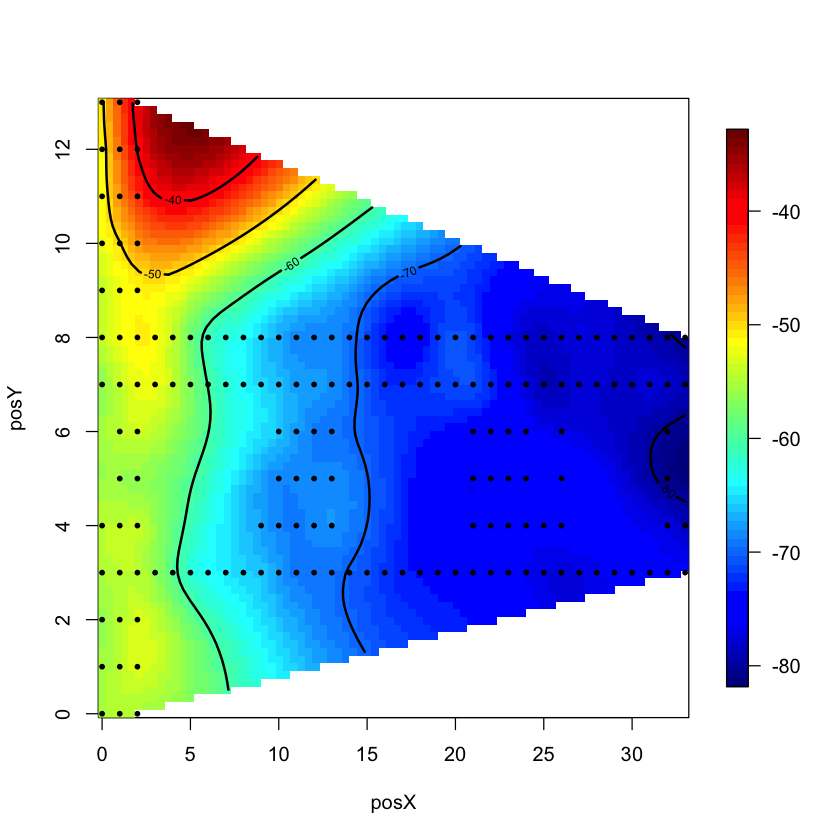

In [51]:
library(fields)
smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
               oneAPAngle$avgSignal)

vizSmooth = predictSurface(smoothSS)

plot.surface(vizSmooth, type = "C")

points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5)

From this figure, it is clear that the dark red region corresponds to the location of the access point located in the top left corner of the floor. 

## Identifying the redundant mac address
We know the locations of the access points based on the floor plan of the building, but we have not been given their exact location and we do not know the mapping between MAC address and access point. Fortunately, the contour maps that we just created make it easy to connect the MAC address to the access point marked on the floor plan in Figure 1.1.

Recall that we have 7 mac addresses and 6 access points. One of the mac address could be from a device/access point on another floor. We can verify this assumption by analysing the relationship between signal and distance.  We first subset the `offlineSummary` dataset by selecting the two mac addresses which seem to be for the same access point located at the center of the floor. 

In [49]:
# 00:0f:a3:39:e1:c0
oneAPAngleMAC_c0 = subset(offlineSummary, 
                    mac == subMacs[1] & angle == 0)

# 00:0f:a3:39:dd:cd
oneAPAngleMAC_cd = subset(offlineSummary, 
                    mac == subMacs[2] & angle == 0)

### Contour plot for mac address: 00:0f:a3:39:e1:c0

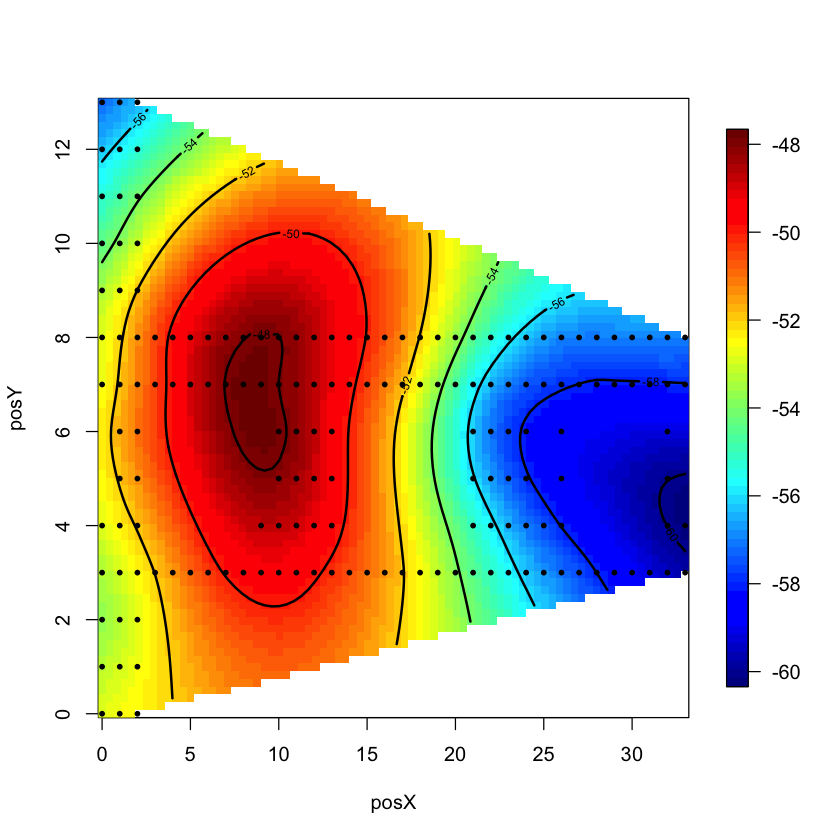

In [52]:
smoothSS = Tps(oneAPAngleMAC_c0[, c("posX","posY")], 
               oneAPAngleMAC_c0$avgSignal)

vizSmooth = predictSurface(smoothSS)

plot.surface(vizSmooth, type = "C")

points(oneAPAngleMAC_c0$posX, oneAPAngleMAC_c0$posY, pch=19, cex = 0.5)

### Contour plot for mac address: 00:0f:a3:39:dd:cd

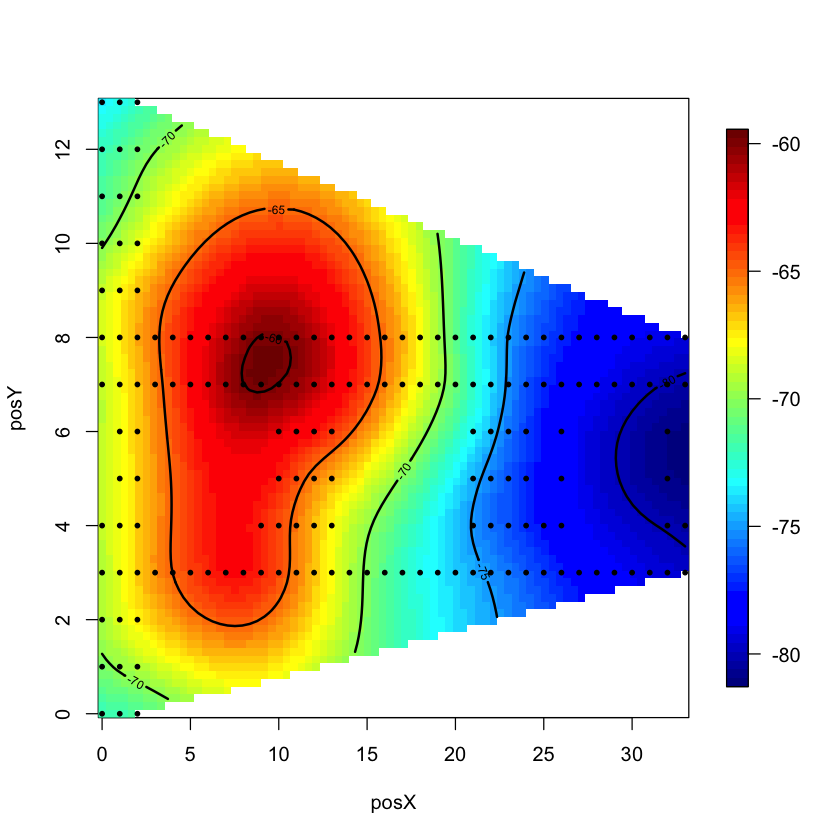

In [53]:
smoothSS = Tps(oneAPAngleMAC_cd[, c("posX","posY")], 
               oneAPAngleMAC_cd$avgSignal)

vizSmooth = predictSurface(smoothSS)

plot.surface(vizSmooth, type = "C")

points(oneAPAngleMAC_cd$posX, oneAPAngleMAC_cd$posY, pch=19, cex = 0.5)

Examining these two contour plots, it is can be observed that the signal strength for mac `00:0f:a3:39:dd:cd` is weaker when compared to the signal strength for mac `00:0f:a3:39:e1:c0`. This gives us a strong cue that the mac address `00:0f:a3:39:dd:cd` is for a device that is not on this floor. 

The ramifications of using mac address `00:0f:a3:39:dd:cd` instead of `00:0f:a3:39:e1:c0`, are that the distances measured from various locations will be inaccurate and will lead to inaccurate predictions of location.

Based on the signal strength analysis we decided to drop `00:0f:a3:39:dd:cd` as a redundant mac address.

We can wrap this plotting routine into its own function so that we can parameterize the MAC address and angle, and if desired, other plotting parameters. Our function, called `surfaceSS()` has 3 arguments:
- data for the offline summary data frame
- mac address
- angle

which supply the MAC address and angle to select the subset of the data that we want smoothed and plotted.

We call surfaceSS() with a couple of MAC addresses and angles to compare them. To do this, we first modify R’s plotting parameters so that we can place 4 contour plots on one canvas, and we reduce the size allocated to the margins so more of the canvas is dedicated to the heat maps. We save the current settings for the plotting parameters in parCur with

ERROR while rich displaying an object: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[1]]) result is length 0

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. mime2repr[[mime]](obj)
8. repr_html.list(obj)
9. repr_list_generic(obj, "html", "\t<li>%s</li>\n", "\t<dt>$%s</dt>\n\t\t<dd>%s</dd>\n", 
 .     "<strong>$%s</strong> = %s", "<ol>\n%s</ol>\n", "<dl>\n%s</dl>\n", 
 .     numeric_item = "\t<dt>[[%s]]</dt>\n\t\

$`00:14:bf:b1:97:90`
NULL

$`00:14:bf:b1:97:90`
NULL

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:e1:c0`
NULL


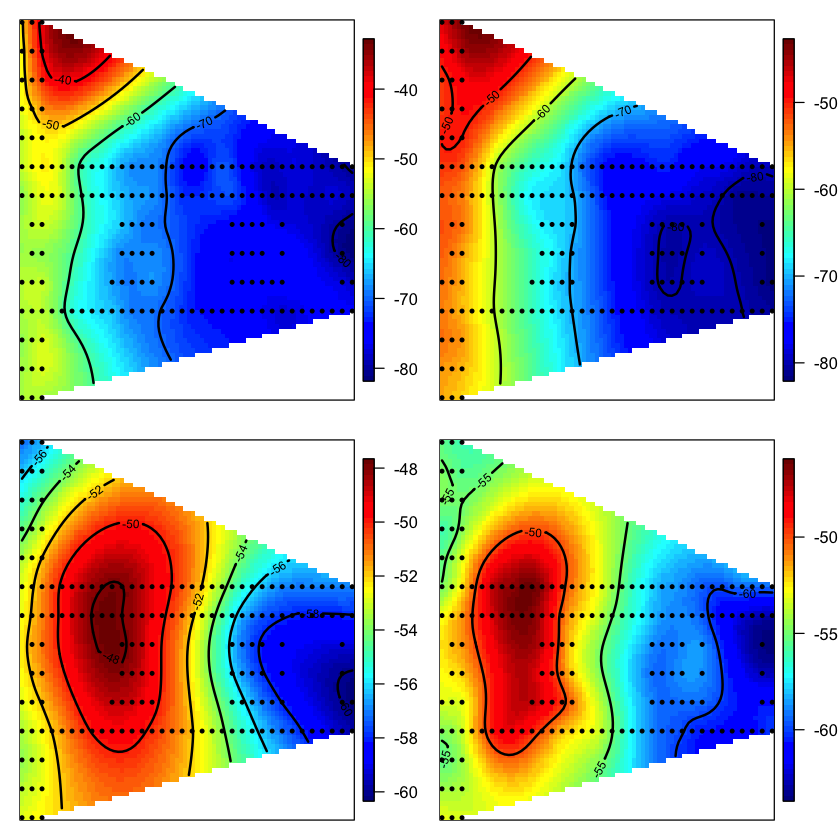

In [54]:
# define function
surfaceSS = function(data, mac, angle = 45) {
  require(fields)
  oneAPAngle = data[ data$mac == mac & data$angle == angle, ]
  smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
                 oneAPAngle$avgSignal)
  vizSmooth = predictSurface(smoothSS)
  plot.surface(vizSmooth, type = "C", 
               xlab = "", ylab = "", xaxt = "n", yaxt = "n")
  points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5) 
}

parCur = par(mfrow = c(2,2), mar = rep(1, 4))

mapply(surfaceSS, mac = subMacs[ rep(c(5, 1), each = 2) ], 
       angle = rep(c(0, 135), 2),
       data = list(data = offlineSummary))
 
par(parCur)

Figure above shows the Median Signal at Two Access Points and Two Angles. These four heat maps provide a smooth topographical representation of signal strength. The top two maps are for the access point 00:14:bf:b1:97:90 and the angles 0 (left) and 135 (right). The two bottom heat maps represent the signal strength for the 00:0f:a3:39:e1:c0 and the same two angles.

We see that we can easily identify the location of the access point as the dark red region at the top of the “mountain.” We also confirm the effect of the orientation on signal strength. Additionally, a corridor effect emerges. The signal is stronger relative to distance along the corridors where the signals are not blocked by walls.

As determined above, we will drop the mac address `00:0f:a3:39:dd:cd` by subsetting it out of the `offlineSummary` dataframe. We create a small matrix with the relevant positions for the 6 access points on the floor plan. 

In [55]:
##TODO This is where we drop the mac address 2
offlineSummary = subset(offlineSummary, mac != subMacs[2])

AP = matrix( c( 7.5, 6.3, 2.5, -.8, 12.8, -2.8,  
                1, 14, 33.5, 9.3,  33.5, 2.8),
            ncol = 2, byrow = TRUE,
            dimnames = list(subMacs[ -2 ], c("x", "y") ))

AP

,x,y
00:0f:a3:39:e1:c0,7.5,6.3
00:14:bf:b1:97:8a,2.5,-0.8
00:14:bf:3b:c7:c6,12.8,-2.8
00:14:bf:b1:97:90,1.0,14.0
00:14:bf:b1:97:8d,33.5,9.3
00:14:bf:b1:97:81,33.5,2.8



To examine the relationship between signal strength and distance from the access point,
we need to compute the distances from the locations of the device emitting the signal to the access point receiving the signal. We first compute the difference between the x coordinate and access point’s x coordinate and the similar difference for the y coordinates. Then we use these differences to find the Euclidean distance between the position of the hand-held device and the access point. Finally, we make a series of scatter plots for each access point and device orientation.

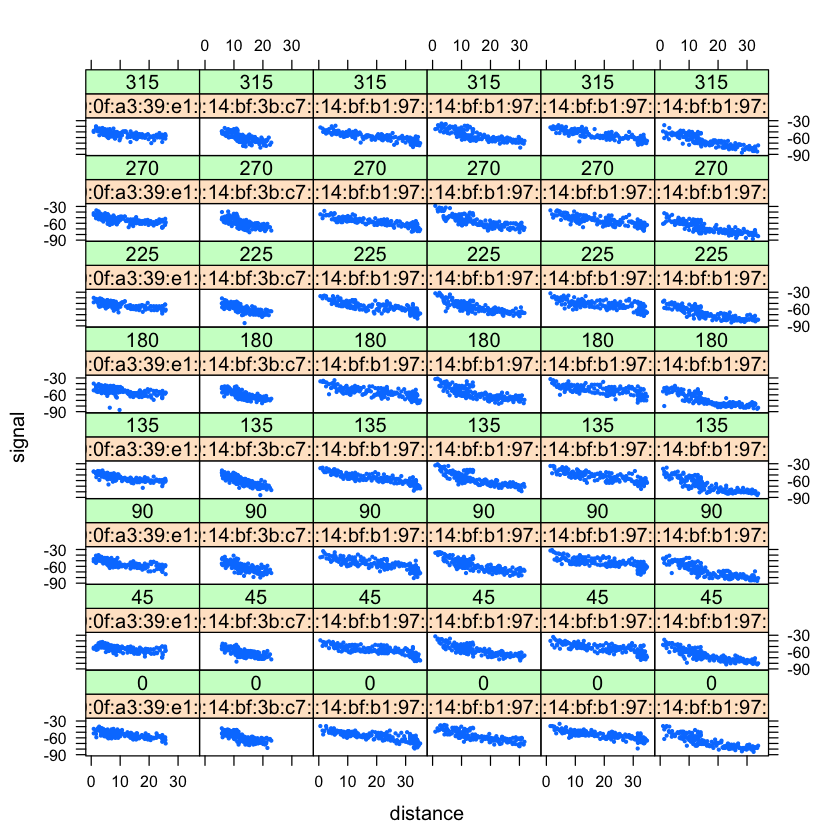

null device 
          1

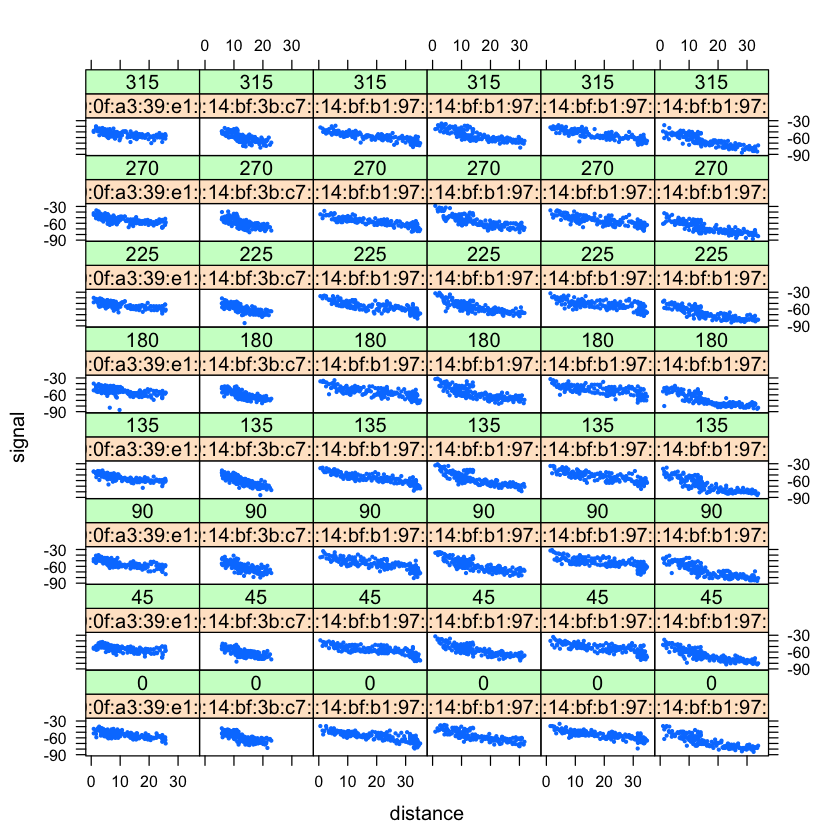

In [56]:
diffs = offlineSummary[ , c("posX", "posY")] - 
          AP[ offlineSummary$mac, ]

offlineSummary$dist = sqrt(diffs[ , 1]^2 + diffs[ , 2]^2)

xyplot(signal ~ dist | factor(mac) + factor(angle), 
       data = offlineSummary, pch = 19, cex = 0.3,
       xlab ="distance")

#pdf(file="Geo_ScatterSignalDist.pdf", width = 7, height = 10)
oldPar = par(mar = c(3.1, 3.1, 1, 1))
library(lattice)
xyplot(signal ~ dist | factor(mac) + factor(angle), 
       data = offlineSummary, pch = 19, cex = 0.3,
       xlab ="distance")
par(oldPar)
dev.off()

macs = unique(offlineSummary$mac)

#### KNN Average Weighting

While there are numerous techniques that exist and could be used to estimate location of a device from the strength of the signal detected between a device and several access points, this case study seeks to use simple KNN clustering approach for location determination. As such, a measure of Euclidean Distance, as depicted in the formula below is used to assess proximity of a test observation to the 166 potential neighbor locations:

<center>$Euclidean Distance =\sqrt{(S_1^*-S_1)^2 + ...+ (S_6^*-S_6)^2}$</center>


In this formula, $S_i$ represents the strength of a signal measured between a hand-held device and an $i$-th training observation access point recorded at a specific location. Similarly, $S_1^*$ represents the signal measured between the same access point and the new point under assessment whose $(x, y)$ coordinates we are trying to predict.


With much of our EDA complete and KNN prediction methodology defined above, we perform a few more preparatory actions before writing our model functions. 

We begin by creating a unique location identifier column in our online data frame as shown below.


In [254]:
online = readData("online.final.trace.txt", subMacs = macs)

online$posXY = paste(online$posX, online$posY, sep = "-")

length(unique(online$posXY))

posXY.unique <- length(unique(online$posXY))


[1] 60

Based on the various X-Y combinations that have now been concatenated into a new column, we have ```r posXY.unique``` unique test locations available in the online dataset. 

The following output depicts 6 randomly sampled location tallies by orientation. This output reveals the signal strength were recorded at only one orientation for each location.

In [255]:
set.seed(100)
tabonlineXYA = table(online$posXY, online$angle)
tabonlineXYA[sample(1:nrow(tabonlineXYA), 6), ]

            
               0  45  90 135 180 225 270 315
  11.39-5      0   0 579   0   0   0   0   0
  10.46-5.8    0 561   0   0   0   0   0   0
  21.6-7.63    0   0   0   0 559   0   0   0
  0.47-8.2   590   0   0   0   0   0   0   0
  16.44-7.45   0   0   0   0   0   0 559   0
  7.48-7.36  590   0   0   0   0   0   0   0

Given what we know about the data from above, we restructure our data into 6 columns of signal strengths rather than only a single signal strength column with all access points as has been done so far. Each access point will now have its own column comprised of its respective Signal strength values. 

This step will make it easier to compute distance between the 6 signal strength vectors.

In [256]:
keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(online, 
             by(online, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 6,
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummary = do.call("rbind", byLoc)  
dim(onlineSummary)

#names(onlineSummary)

head(onlineSummary)

[1] 60 11

,posXY,posX,posY,orientation,angle,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0-0.05,0-0.05,0.00,0.05,130.5,135,-52,-63,-62,-40,-63,-55
0.15-9.42,0.15-9.42,0.15,9.42,112.3,90,-55,-74,-73,-48,-69,-47
0.31-11.09,0.31-11.09,0.31,11.09,230.1,225,-52,-70,-70,-54,-69,-54
0.47-8.2,0.47-8.2,0.47,8.20,5.8,0,-50,-64,-73,-46,-61,-50
0.78-10.94,0.78-10.94,0.78,10.94,348.3,0,-53,-67,-67,-48,-65,-55
0.93-11.69,0.93-11.69,0.93,11.69,158.3,180,-58,-70,-71,-44,-66,-47


From above table we have 11 columns are present in our onlineSummary, including the concatinated X-Y values, X and Y values in their separate columns, orientation, angle, and the 6 access points' average Signal Strength values.

In our KNN prediction, our objective is to find offline data points with similar orientations to our new location points since we discovered orientation impacts signal strength during our EDA efforts. To achieve this, we select all records within a specified range of the test point's orientation. Since all observations were recorded in 45 degree increments, this becomes as easy as specifying the number of neighboring angles to include from the offline dataset. For even numbers, this means selecting even multiples of 45 degrees on each side of a test observation's orientation angle. For odd numbers, it means selecting offline data with angles which match the new observation's rounded orientation as well as those that flank the new observation's angle. In the case where only one orientation is desired, offline data with angles matching the new observation's will be selected only. The procedures to perform these actions, and to create a data structure aggregating the Signal strenght values from these angles, are as follows.[1]

In [257]:
reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY")) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}


selectTrain = function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles)
  
  offlineSubset = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset, varSignal = "avgSignal")
}

To illustrate the performance of the above functions, we show the data structure created for an angle of 130 degrees using 3 angles in total (only first 6 rows shown). 

This is an aggregation for angles of 90, 135, and 180 degrees. Note the average signal strengths are computed for the different angles by the *selectTrain()* function and that one set of signal strengths is created for each of the offline dataset's 166 locations

In [258]:
train130 = selectTrain(130, offlineSummary, m = 3)

head(train130)

length(train130[[1]])

,posXY,posX,posY,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0-0,0-0,0,0,-52,-66,-63,-36,-64,-55
0-1,0-1,0,1,-53,-65,-64,-39,-65,-59
0-10,0-10,0,10,-56,-66,-69,-45,-67,-50
0-11,0-11,0,11,-55,-67,-70,-48,-67,-55
0-12,0-12,0,12,-56,-70,-72,-45,-67,-50
0-13,0-13,0,13,-55,-71,-73,-43,-69,-54


[1] 166

Our next step is to define a function to calculate distances between new points and all offline dataset observations. The following *findNN()* function is constructed to do just that. The paramaters for this function are a numeric vector of 6 new signal strengths along with 6 offline signal strengths as output from the *selectTrain()* function.

In [259]:
findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}


Our first KNN prediction averages the first k locations returned by the *findNN()* function. This procedure, along with the *findNN()*, *selectTrain()*, and *reshapeSS()* function calls, are embedded in the *predXY()* wrapper function as below.

In [260]:
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = 
      findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  }

  estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}

Using the *predXY()* function, we illustrate location prediction accuracy for $k = 3$ and $k = 1$ KNN training counts. Furthermore, model fit is assessed by mapping actual and predicted locations with lines connecting the two points for each respective new observation. 

The map is first drawn for the 3-NN predictions below.

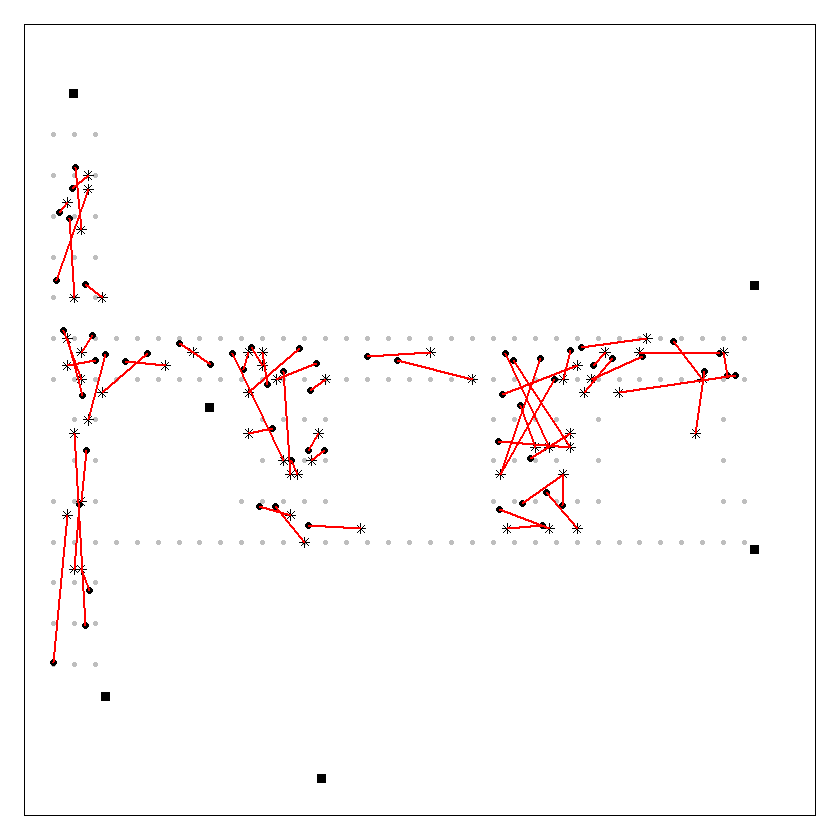

In [261]:
estXYk3 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 3)
estXYk1 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 1)
floorErrorMap = function(estXY, actualXY, trainPoints = NULL, AP = NULL){
  
    plot(0, 0, xlim = c(0, 35), ylim = c(-3, 15), type = "n",
         xlab = "", ylab = "", axes = FALSE)
    box()
    if ( !is.null(AP) ) points(AP, pch = 15)
    if ( !is.null(trainPoints) )
      points(trainPoints, pch = 19, col="grey", cex = 0.6)
    
    points(x = actualXY[, 1], y = actualXY[, 2], 
           pch = 19, cex = 0.8 )
    points(x = estXY[, 1], y = estXY[, 2], 
           pch = 8, cex = 0.8 )
    segments(x0 = estXY[, 1], y0 = estXY[, 2],
             x1 = actualXY[, 1], y1 = actualXY[ , 2],
             lwd = 2, col = "red")
}

trainPoints = offlineSummary[ offlineSummary$angle == 0 & 
                              offlineSummary$mac == "00:0f:a3:39:e1:c0" ,
                        c("posX", "posY")]

oldPar = par(mar = c(1, 1, 1, 1))
floorErrorMap(estXYk3, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)

We draw the same map for 1-NN predictions next. 

We note that upon comparison, errors are generally smaller for the 3-NN model than they are for 1-NN and that the largest errors tend to follow hallways rather than traverse large obstacles such as walls or other stationary barriers.

null device 
          1

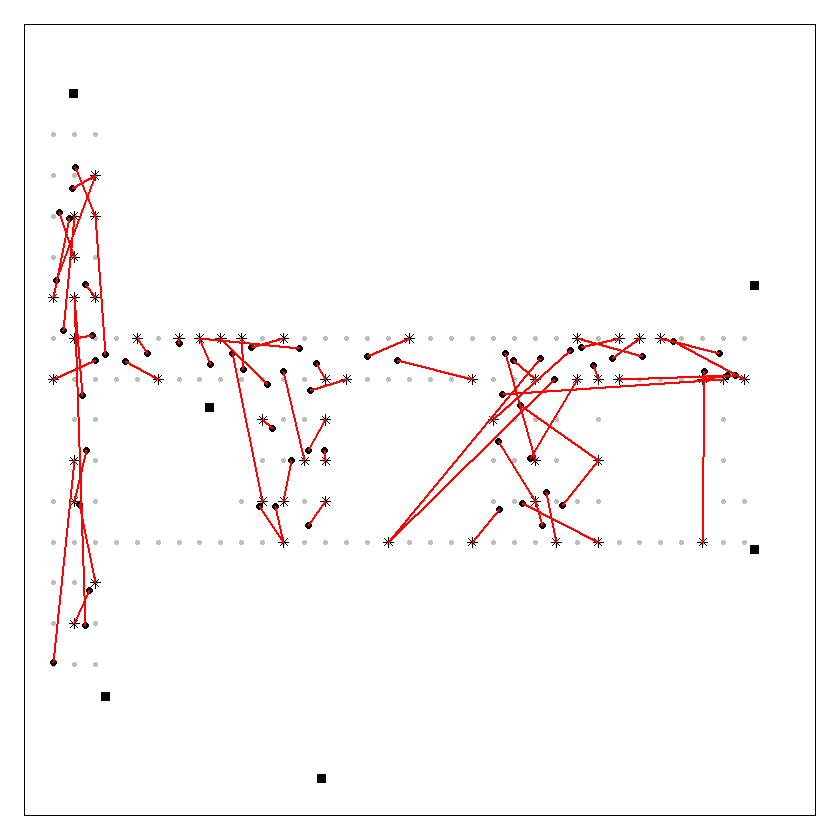

In [262]:
oldPar = par(mar = c(1, 1, 1, 1))
floorErrorMap(estXYk1, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)
par(oldPar)
dev.off()

In addition to the visual comparisons above, we perform numeric comparison of the predicted and actual positions. We assess fits for the 3-NN and 1-NN models by comparing their Sum of Squared Error (SSE) values as follows.

In [263]:
calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

actualXY = onlineSummary[ , c("posX", "posY")]
sapply(list(estXYk1, estXYk3), calcError, actualXY)

[1] 659 307

The results above confirm what we saw in the figures that the 3 nearest neighbours do a better job for predicting location than one nearest neighbor.

### Cross-Validation and Choosing k

One question that still lingers in our mind is whether there is a value of $k$ that will give a better prediction.

Below we assess selection of a value of $k$. To avoid overfitting, we must select the optimal value of k independent of our test observations. 

We use v-fold cross validation to do so. A $v$ value of 11 is selected since we have 166 different offline locations, allocating 15 locations to each fold. Allocations are randomly selected as follows.

In [264]:
v = 11
permuteLocs = sample(unique(offlineSummary$posXY))
permuteLocs = matrix(permuteLocs, ncol = v, 
                     nrow = floor(length(permuteLocs)/v))

onlineFold = subset(offlineSummary, posXY %in% permuteLocs[ , 1])
head(onlineFold)
onlineFold.ul <- nrow(unique(onlineFold[,2:3]))

Warning message in matrix(permuteLocs, ncol = v, nrow = floor(length(permuteLocs)/v)):
"data length [166] is not a sub-multiple or multiple of the number of rows [15]"

,time,posX,posY,orientation,mac,signal,rawTime,angle,posXY,medSignal,avgSignal,num,sdSignal,iqrSignal,dist
397974,2006-02-11 09:50:44,10,4,0.4,00:0f:a3:39:e1:c0,-54,1.1e+12,0,10-4,-50,-50,109,1.99,3,3.4
523276,2006-02-11 12:44:33,10,8,0.6,00:0f:a3:39:e1:c0,-43,1.1e+12,0,10-8,-45,-45,110,1.13,2,3.0
384774,2006-02-11 09:33:55,13,3,359.6,00:0f:a3:39:e1:c0,-55,1.1e+12,0,13-3,-52,-52,110,0.85,1,6.4
1142766,2006-03-09 13:40:37,15,8,359.1,00:0f:a3:39:e1:c0,-44,1.1e+12,0,15-8,-45,-45,110,1.08,2,7.7
1155541,2006-03-09 13:52:51,17,8,1.2,00:0f:a3:39:e1:c0,-48,1.1e+12,0,17-8,-52,-52,110,1.37,2,9.7
1116679,2006-03-09 13:08:54,18,7,0.4,00:0f:a3:39:e1:c0,-48,1.1e+12,0,18-7,-47,-48,110,2.93,4,10.5


Similary to how we summarized our offline data into a structure containing 6 signal strength columns, one for each access point, we will do the same with our cross-validated test data. 

It is easier to structure the test data in its complete form from offline data which is then divided into our desired folds. We also need to modify the *reshapeSS()* function as follows to select one angle at random for each location. 

In [265]:
reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

With our cross validated data created and *reshapeSS()* function modified, We now proceed to summarize and format the offline data using the updated *reshapeSS()* function to produce our online cross-validation summary data structure as below.

In [266]:
offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")

onlineCVSummary = reshapeSS(offline, keepVars = keepVars, 
                            sampleAngle = TRUE)

head(onlineCVSummary)

,posXY,posX,posY,orientation,angle,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0-0,0-0,0,0,180,180,-55,-68,-62,-34,-66,-56
0-1,0-1,0,1,270,270,-56,-67,-69,-39,-66,-55
0-10,0-10,0,10,270,270,-57,-63,-63,-41,-64,-58
0-11,0-11,0,11,90,90,-57,-71,-69,-51,-67,-55
0-12,0-12,0,12,315,315,-52,-68,-71,-50,-69,-55
0-13,0-13,0,13,225,225,-56,-71,-71,-45,-69,-57


In [267]:
onlineFold = subset(onlineCVSummary, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 3, k = 3)

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

[1] 156

Next we calculate the SSE values for each value of k between 1 and 20. Doing so allows us to choose the k value which produces the smallest error among all k options.

In [268]:
set.seed(100)
K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 3, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}

The SSE values produced for $k = 1$ through $k = 20$ are plotted for easy review. The below figure plots the sum of fold SSE values with respect to each k count

[1] 5


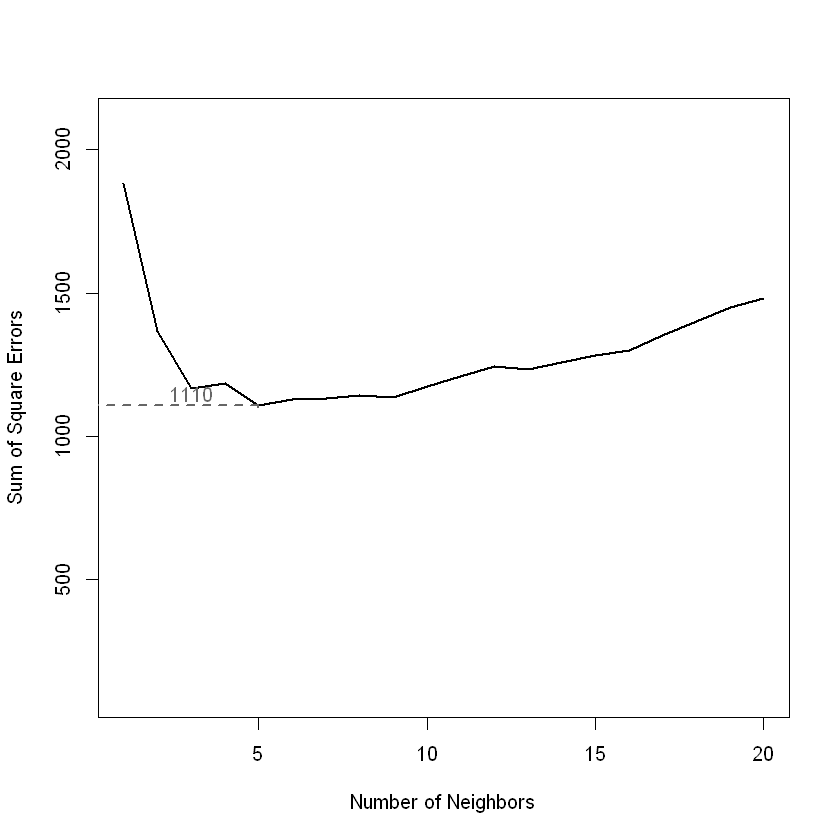

In [269]:
#pdf(file = "Geo_CVChoiceOfK.pdf", width = 10, height = 6)
#oldPar = par(mar = c(4, 3, 1, 1))
plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(100, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))
#par(oldPar)
#dev.off()
print(kMin)

Based on our analysis, $k =$ 5 produces the least amount of error. With our optimal k defined, we may proceed with estimation to calculate final Sum of Squared Errors. We store the SSE in a avriable SSE.k5 for future comparison.

In [270]:
#set.seed(100)
#mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))
estXYk5 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 5)

calcError(estXYk5, actualXY)

[1] 276

In [271]:
SSE.k5 = calcError(estXYk5, actualXY)

### KNN Distance Weighting

When estimating position by average X-Y location across k nearest points, one is bound to wonder if  distance of those points play any significance to the accuracy of the model.

We check this by applying weights to the X-Y positions of each k closest locations and take the sum of those results instead of averaging the values. We use below formula to compute weights for each k closest observations.

$$
\begin{aligned}
\frac{1/d_i}{\sum_{i=1}^{k}1/d_i}
\end{aligned}
$$

We have modified the *findNN()* function below from the previous version to output distance metrics utilized in determining the "closest" k points. 

The *predXY()* function has also been modified to compute weights with the formula above and distance outputs from the *findNN()* output. These weights are multiplied against each k nearest observation, respectively, then summed to compute a weighted estimation by distance. 

In [272]:
#Modified findNN() to output distances
findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(list(trainSubset[closest, 1:3 ],dists[order(dists)]))
}

##### modify predXY function

In [273]:
#Modify PredXY function to utilize distance output from FindNN
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  closeDist = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    fnnResult =
    findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  
    closeXY[[i]] = fnnResult[[1]]
    closeDist[[i]] = fnnResult[[2]]
  }
  
  
  distWeight = list(length = length(closeDist))
  
  for (i in 1:length(closeDist)){
    distW = list(length = k)

    for (j in 1:k){
      distW[j] = (1/closeDist[[i]][j])/sum(1/closeDist[[i]][1:k])
    }
     
    distWeight[[i]] =  distW
  }

  estXYDetails = list(length=length(closeXY))
  
  for(i in 1:length(closeXY)){
    estXYDetails[[i]] = as.matrix(closeXY[[i]][1:k,2:3]) * unlist(distWeight[[i]])
  }
  

  estXY = lapply(estXYDetails,
                 function(x) apply(x, 2,
                                   function(x) sum(x)))
  
  
  estXY = do.call("rbind", estXY)
  return(estXY)
}

We once again perfom k-fold cross validation and k selection

In [274]:
#set.seed(100)
K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 3, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}

Below we plot  SSE values for the 20 k test iterations. 

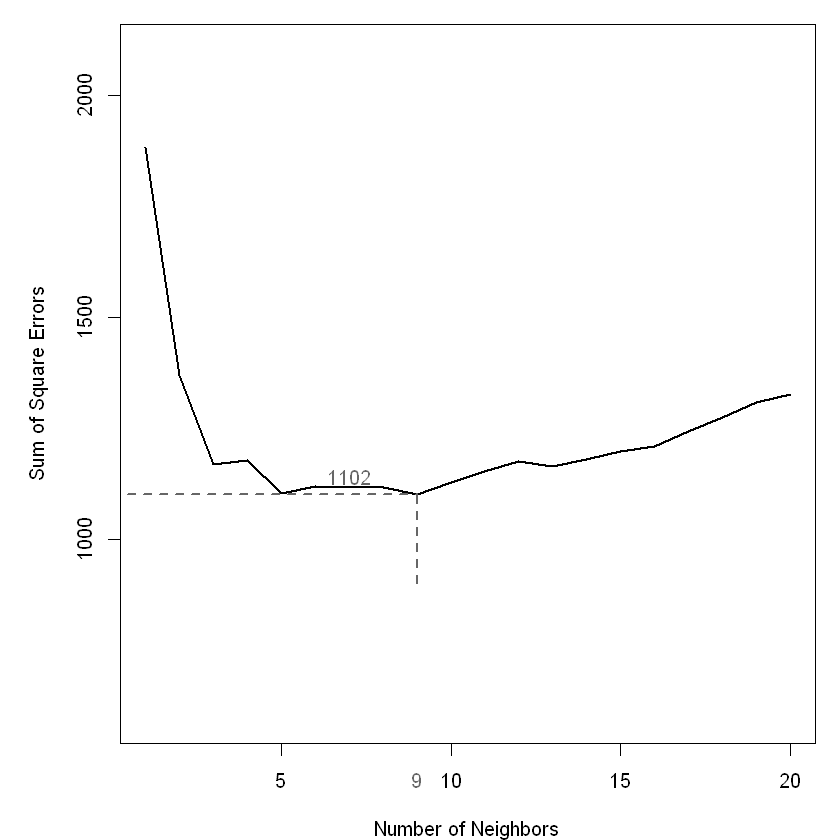

In [275]:
oldPar = par(mar = c(4, 5, 1, 1))
plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(600, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin2 = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin2, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin2, x1 = kMin2, y0 = 900,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

mtext(kMin2, side = 1, line = 1, at = kMin2, col = grey(0.4))
text(x = kMin2 - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))
par(oldPar)

From above, tha optimal number k is 9. We  proceed to compute predictions using the weighted distance estimation method. We store the SSE values for comparison to the average location methods from above section.

In [276]:
#set.seed(100)
estXYk6 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = kMin2)

SSE.k6 <- calcError(estXYk6, actualXY)

In [277]:
kMin2

[1] 9

#### KNN Comparison

Having obtained the optimal prediction method inputs defined for both average location estimation and weighted distance estimation, we compare estimations both visually and through SSE values.

Looking at the Average location estimates plots below, both models `Average Location Estimates vs Actual` and `Weighted Distance Estimates vs Actual`,  struggle the most in narrow hallways. The plots gives us a good visual of how accurate the predictions were.

Visually both models seem to give very similar results. We will use SSE values to guage which one of the two is superior.

[1] "Average Location Estimates vs Actual"


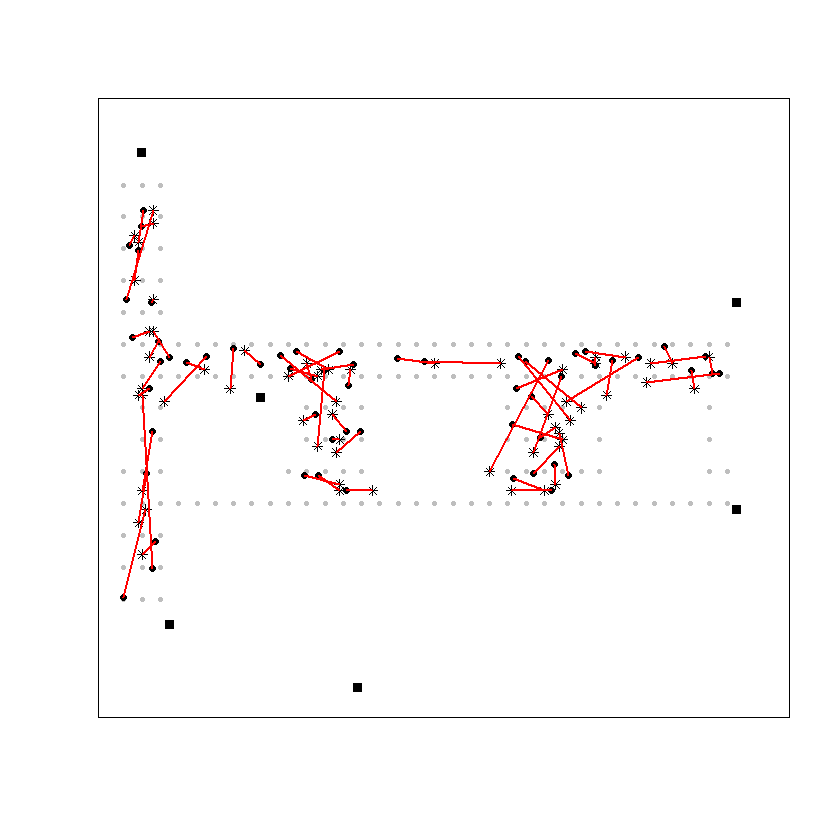

In [278]:
print("Average Location Estimates vs Actual")
oldPar = par(mar = c(1, 1, 1, 1))
par(oldPar)
floorErrorMap(estXYk5, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)



[1] "Weighted Distance Estimates vs Actual"


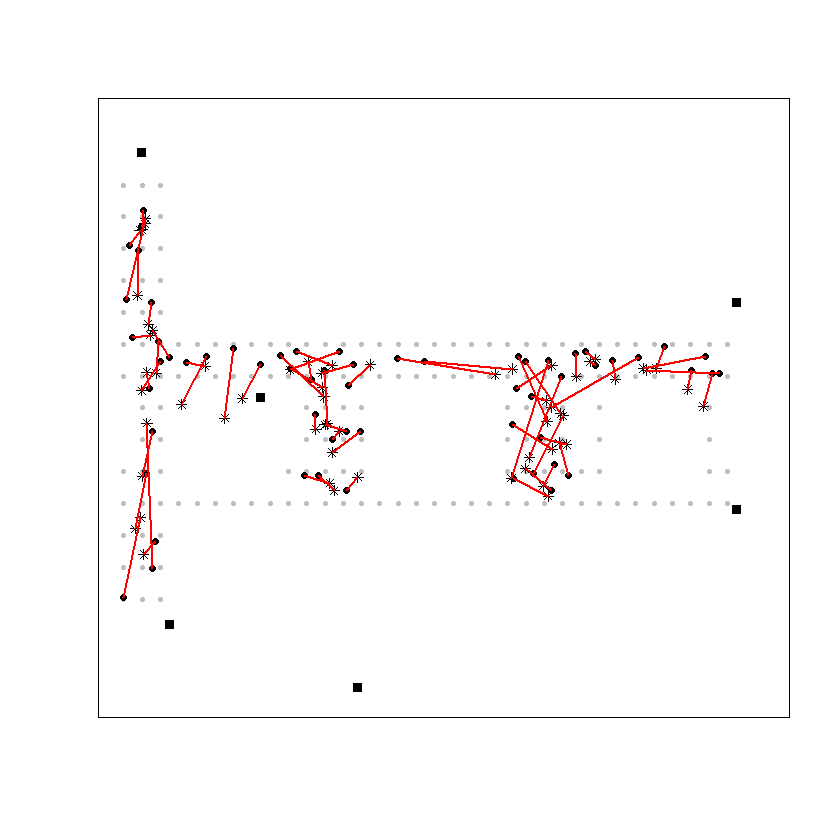

In [279]:
print('Weighted Distance Estimates vs Actual')
oldPar = par(mar = c(1, 1, 1, 1))
par(oldPar)
floorErrorMap(estXYk6, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)

Comparing SSE

In [280]:
print(paste('Average Location Estimates vs Actual Error: ',SSE.k5))

[1] "Average Location Estimates vs Actual Error:  275.5083"


In [281]:
print(paste('Weighted Distance Estimates vs Actual Error: ',SSE.k6))

[1] "Weighted Distance Estimates vs Actual Error:  276.471720300513"


As from the visual plots above, the SSE for the two models are pretty close. Average Location Estimates has a slight edge over Weighted Distance Estimates 

## Conclusion

As RTLS usage increases, the need for accurate indoor location prediction models increases as well. In this case study, we've explored location datasets for both online and offine, We have performed a comprehensive exploratory data analysis, and have generated kNN models with both averaged X-Y coordinates as well as weighted coordinates as a function of distance for signal strength.

Both models performed relatively the same when evaluated visually. Digging deeper into the errors in prediction,Average Location Estimates has a slight edge over Weighted Distance Estimates. It gave us the least error as such we would consider choosing Average Location Estimates implementing our RTLS system in production

## References

[1] D. Lang and D. Nolan, Data Science in R: A Case Studies Approach to Computation Reasoning and Problem Solving. New York, New York: CRC Press.